# [AIG100 – Project 3: Income Classification using Neural Networks](hhttp://github.com/jcp-tech/Seneca_Class_Notes/blob/master/Semester%201/AIG100%20-%20Machine%20Learing/Project%203/Project%203%20-%20AIG100%20-%20Jonathan%20Chacko.ipynb)

## Table of Contents

1. [Introduction](#Introduction)
2. [Dataset Overview & Significance](#Dataset-Overview--Significance)
3. [Data Cleaning & Preprocessing](#Data-Cleaning--Preprocessing)
   - [Loading the Dataset](#Loading-the-Dataset)
   - [Data Cleaning Steps](#Data-Cleaning-Steps)
4. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
   - [Analysis of Numerical Features](#Analysis-of-Numerical-Features)
   - [Analysis of Categorical Features](#Analysis-of-Categorical-Features)
5. [Data Preprocessing & Feature Engineering](#Data-Preprocessing--Feature-Engineering)
   - [Train-Test Split and Class Distribution](#Train-Test-Split-and-Class-Distribution)
   - [Handling Class Imbalance](#Handling-Class-Imbalance)
6. [Modeling Approach](#Modeling-Approach)
7. [Evaluation & Results](#Evaluation--Results)
   - [Cross-Validation Performance](#Cross-Validation-Performance)
   - [Model Architecture Summary](#Model-Architecture-Summary)
   - [Learning Curves](#Learning-Curves)
   - [Final Test Set Evaluation](#Final-Test-Set-Evaluation)
   - [Confusion Matrix Visualization](#Confusion-Matrix-Visualization)
   - [Per-Class Performance Metrics](#Per-Class-Performance-Metrics)
   - [ROC Curve Analysis](#ROC-Curve-Analysis)
   - [Precision-Recall Curve](#Precision-Recall-Curve)
8. [Model Interpretation & Insights](#Model-Interpretation--Insights)
   - [Key Findings](#Key-Findings)
   - [Model Performance Analysis](#Model-Performance-Analysis)
   - [Feature Importance Observations](#Feature-Importance-Observations)
9. [Real-World Applications & Implications](#Real-World-Applications--Implications)
   - [Use Cases in Financial Services](#Use-Cases-in-Financial-Services)
   - [Ethical Considerations](#Ethical-Considerations)
   - [Limitations & Potential Improvements](#Limitations--Potential-Improvements)
10. [Reflection](#Reflection)
11. [Conclusion](#Conclusion)
12. [References](#References)

## Introduction

### Project Title
**Predicting Loan Default Risk Using Census Income Data**

### Objective
To build a neural network model that classifies individuals as low-risk or high-risk loan applicants, based on demographic and socio-economic data from the UCI Census Income dataset.

### Background
Financial institutions face the constant challenge of determining whether a loan applicant is likely to default. Traditionally, this involves credit history and financial statements—but what if we could leverage broader demographic and employment features to predict credit risk?

By classifying whether a person earns more than $50K per year using neural networks, we indirectly estimate their income capacity, a crucial factor in loan repayment ability. High-income individuals are typically lower-risk, while lower-income applicants may pose greater risk, especially without collateral or prior credit history.

<!-- 
### Note
I decided to Approach this Project with a more practical Perspective to see if i can solve a Problem with the Data in Hand. 
-->

## Dataset Overview & Significance

### Dataset Details
- **Source**: [UCI Census Income Dataset](https://archive.ics.uci.edu/dataset/20/census+income)
- **Structure**: ~48,842 rows, 14 feature columns plus target variable
- **Target Variable**: `income` (binary: >$50K or ≤$50K)
<!-- - **Class Distribution**: Approximately 75% ≤$50K, 25% >$50K (imbalanced) -->

### Why This Project Matters

This project addresses a critical business need in the financial sector: accurately assessing loan default risk. Traditional methods rely heavily on credit history, which disadvantages those with limited credit records (the "thin file" problem). By leveraging demographic and socioeconomic data, we can create more inclusive risk assessment models.


## Data Cleaning & Preprocessing

In [59]:
# === General Libraries ===
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo 

# === Data Preprocessing ===
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder # , OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight

# === Evaluation Metrics ===
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    # mean_squared_error, r2_score, mean_absolute_error,
    precision_recall_curve, average_precision_score,
    roc_curve, roc_auc_score # , auc
)

# === TensorFlow / Keras ===
import tensorflow as tf
# from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Dense, Dropout, BatchNormalization,
    # Input, Flatten, Embedding, Concatenate, Reshape,
    LeakyReLU
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model

# === Others ===
import os
import math
import shutil

# Ignore warnings for cleaner output
warnings.filterwarnings('ignore')

### Loading the Dataset

In [2]:
# fetch dataset
census_income = fetch_ucirepo(id=20) # https://archive.ics.uci.edu/dataset/20/census+income
# print(census_income.metadata) # metadata 
# print(census_income.variables) # variable information 
df = pd.concat([census_income.data.features, census_income.data.targets], axis=1)
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K.
48838,64,NaN,321403,HS-grad,9,Widowed,NaN,Other-relative,Black,Male,0,0,40,United-States,<=50K.
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K.
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K.


In [3]:
df.shape

(48842, 15)

In [4]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

In [5]:
df.isnull().sum() # check for null values

age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
income              0
dtype: int64

In [6]:
# Showing the Values in Each Column
for col in df.columns:
    print(f"Column: `{col}`")
    print(df[col].unique())
    print("\n")

Column: `age`
[39 50 38 53 28 37 49 52 31 42 30 23 32 40 34 25 43 54 35 59 56 19 20 45
 22 48 21 24 57 44 41 29 18 47 46 36 79 27 67 33 76 17 55 61 70 64 71 68
 66 51 58 26 60 90 75 65 77 62 63 80 72 74 69 73 81 78 88 82 83 84 85 86
 87 89]


Column: `workclass`
['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov' '?'
 'Self-emp-inc' 'Without-pay' 'Never-worked' nan]


Column: `fnlwgt`
[ 77516  83311 215646 ... 173449  89686 350977]


Column: `education`
['Bachelors' 'HS-grad' '11th' 'Masters' '9th' 'Some-college' 'Assoc-acdm'
 'Assoc-voc' '7th-8th' 'Doctorate' 'Prof-school' '5th-6th' '10th'
 '1st-4th' 'Preschool' '12th']


Column: `education-num`
[13  9  7 14  5 10 12 11  4 16 15  3  6  2  1  8]


Column: `marital-status`
['Never-married' 'Married-civ-spouse' 'Divorced' 'Married-spouse-absent'
 'Separated' 'Married-AF-spouse' 'Widowed']


Column: `occupation`
['Adm-clerical' 'Exec-managerial' 'Handlers-cleaners' 'Prof-specialty'
 'Other-service' 'Sales' 'Craft-repair' '

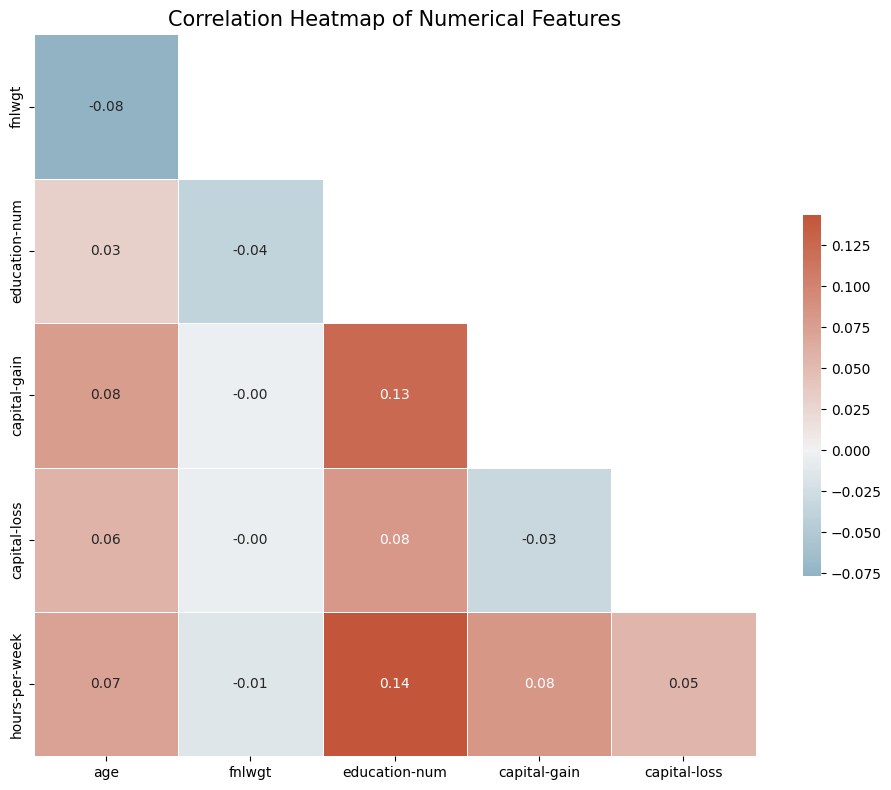

In [7]:
numeric_df = df.select_dtypes(include=['int64', 'float64']) # Create a copy of the dataframe with only numeric columns
corr_matrix = numeric_df.corr() # Compute correlation matrix
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) # Apply mask
corr_matrix_trimmed = corr_matrix.iloc[1:, :-1]
mask_trimmed = mask[1:, :-1]
plt.figure(figsize=(10, 8))# Plot heatmap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(
    corr_matrix_trimmed,
    mask=mask_trimmed,
    annot=True,
    fmt='.2f',
    cmap=cmap,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={'shrink': 0.5}
)
plt.title('Correlation Heatmap of Numerical Features', fontsize=15)
plt.tight_layout()
plt.show()

In [8]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


### Data Cleaning Steps

In [9]:
# 1. Handling missing values (replacing `'?'` with `NaN` and dropping rows)
df[df=='?']=np.nan # Replacing '?' with NaN
df=df.dropna(axis=0) # Dropping all rows with NaN values
# df = df[~(df['native-country'] == "?") | (df['native-country'].isnull())] # ALTERNATIVE Removing all rows with Unknown Countries as part of data cleaning process

In [10]:
# 2. Transforming categorical variables (age binning)
df['age'] = pd.cut(df['age'], bins=[0, 30, 60, 100], labels=['Young', 'Middle-aged', 'Old']) # .astype('category')

In [11]:
# 3. Feature engineering (creating capital-profit from gain/loss)
df['capital-metrics'] = df['capital-gain'] - df['capital-loss']
df['capital-profit'] = df['capital-metrics'].apply(lambda x: 0 if x < 0 else 1)
df.drop(columns=['capital-gain', 'capital-loss', 'capital-metrics'], inplace=True)

In [12]:
df.info() # check the data types and null values

<class 'pandas.core.frame.DataFrame'>
Index: 45222 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             45222 non-null  category
 1   workclass       45222 non-null  object  
 2   fnlwgt          45222 non-null  int64   
 3   education       45222 non-null  object  
 4   education-num   45222 non-null  int64   
 5   marital-status  45222 non-null  object  
 6   occupation      45222 non-null  object  
 7   relationship    45222 non-null  object  
 8   race            45222 non-null  object  
 9   sex             45222 non-null  object  
 10  hours-per-week  45222 non-null  int64   
 11  native-country  45222 non-null  object  
 12  income          45222 non-null  object  
 13  capital-profit  45222 non-null  int64   
dtypes: category(1), int64(4), object(9)
memory usage: 4.9+ MB


In [13]:
# 4. Removing irrelevant features
df.drop(columns=['fnlwgt', 'education'], inplace=True) # Dropping the fnlwgt and education columns as they are not relevant to the analysis
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [14]:
# 5. Standardizing the target variable
df['income'] = df['income'].str.replace('.', '')
df['income'].replace({'<=50K': 0, '>50K': 1}, inplace=True)
# df['income'] = df['income'].astype('category')
df['income'].value_counts()

income
0    34014
1    11208
Name: count, dtype: int64

## Exploratory Data Analysis

In [15]:
# Separate features
numerical_features_temp = df.select_dtypes(include=['int64', 'float64']).drop(columns=['income', 'capital-profit']).columns.tolist()
categorical_features_temp = df.select_dtypes(include=['object', 'category']).columns.tolist()

### Analysis of Numerical Features

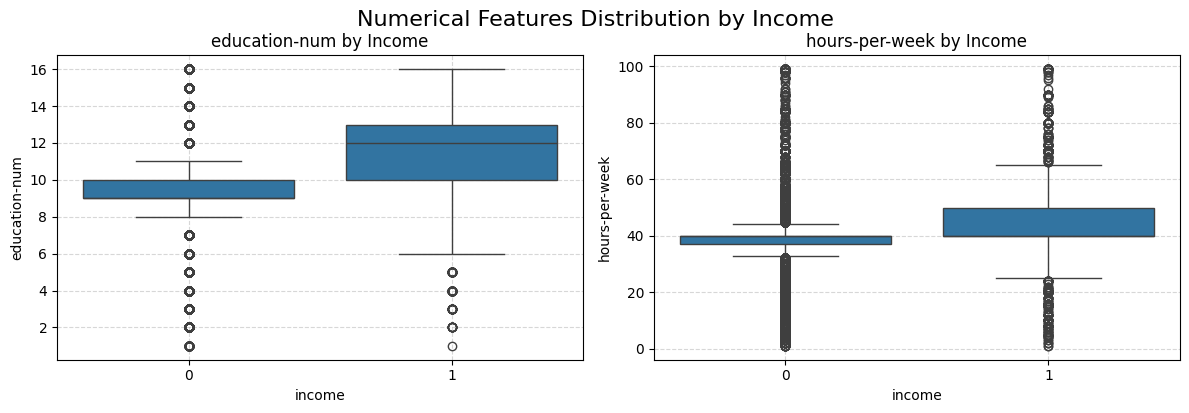

In [16]:
# === NUMERICAL FEATURES ===
num_cols = 2
num_rows = math.ceil(len(numerical_features_temp) / num_cols)
plt.figure(figsize=(num_cols * 6, num_rows * 4))

for i, feature in enumerate(numerical_features_temp):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.boxplot(data=df, x='income', y=feature)
    plt.title(f"{feature} by Income")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()

plt.suptitle("Numerical Features Distribution by Income", y=1.02, fontsize=16)
plt.show()

### Analysis of Categorical Features

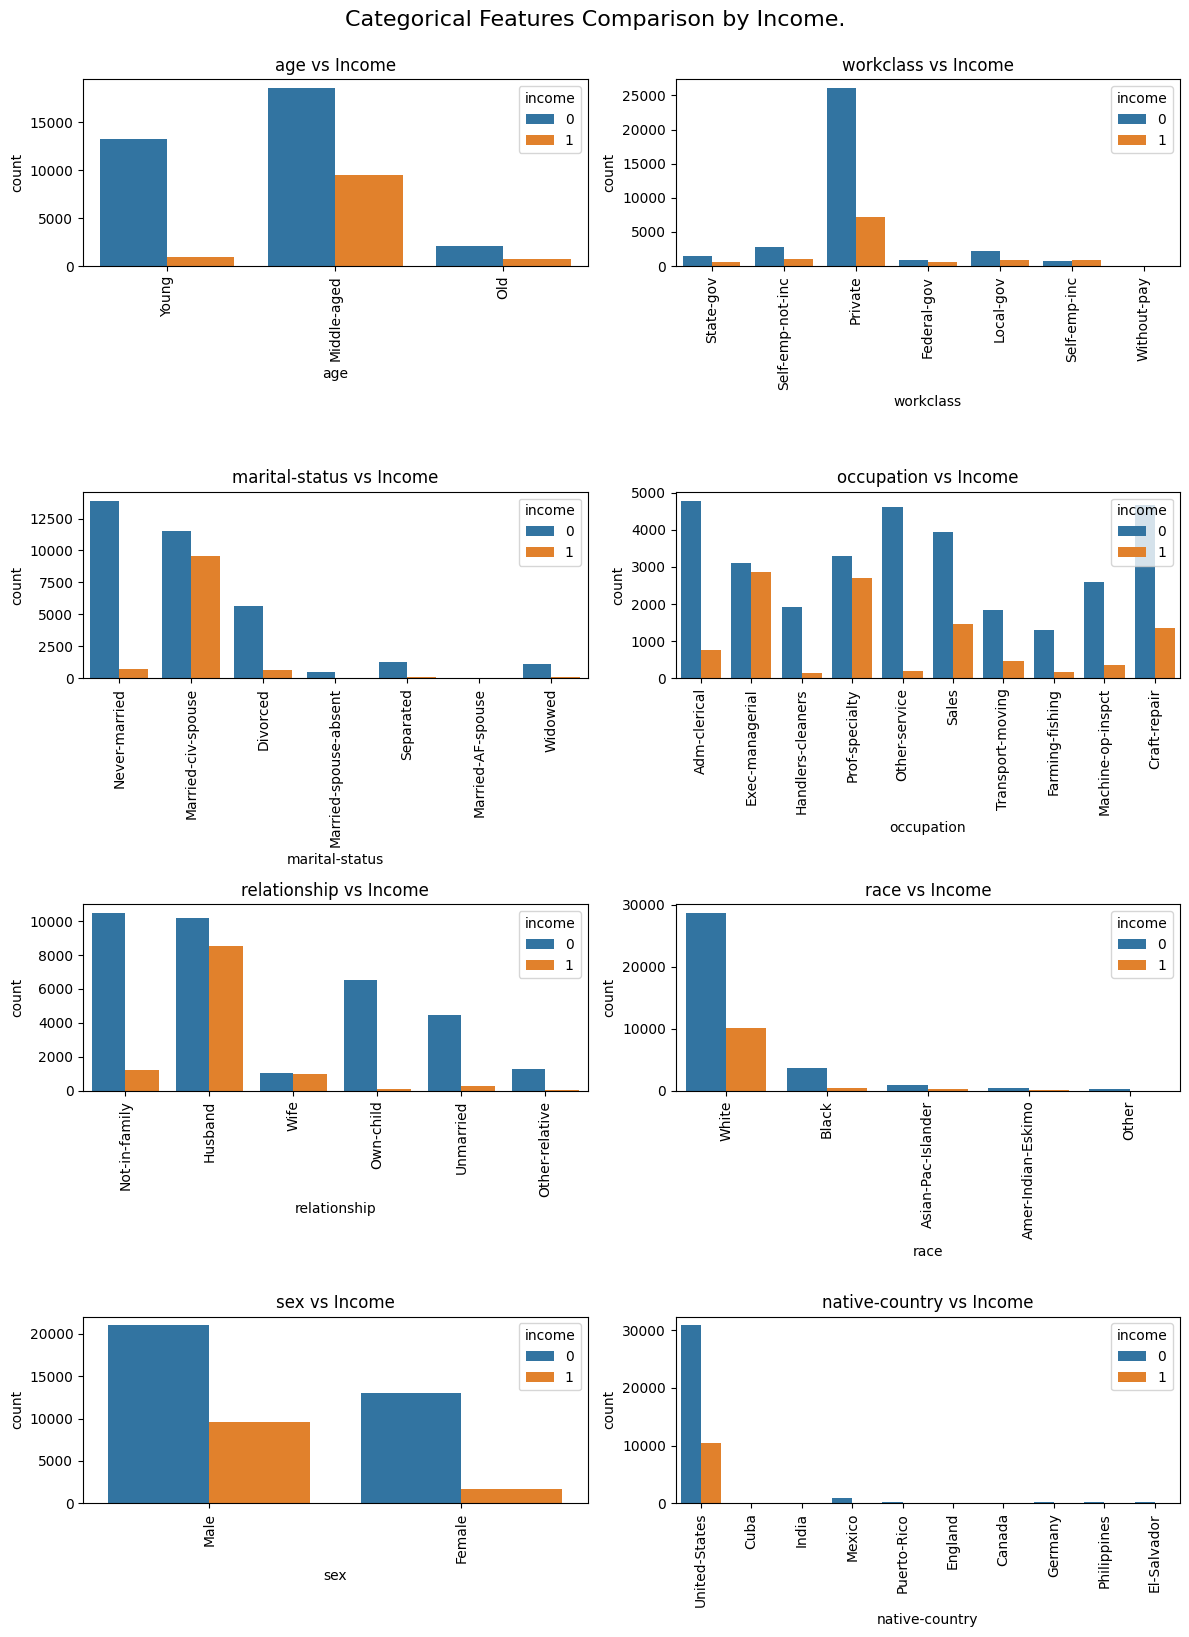

In [17]:
# === CATEGORICAL FEATURES ===
cat_cols = 2
cat_rows = math.ceil(len(categorical_features_temp) / cat_cols)
plt.figure(figsize=(cat_cols * 6, cat_rows * 4))

for i, feature in enumerate(categorical_features_temp):
    plt.subplot(cat_rows, cat_cols, i + 1)

    # Get top 10 most common categories (if needed)
    top_categories = df[feature].value_counts().nlargest(10).index
    filtered_df = df[df[feature].isin(top_categories)]

    sns.countplot(data=filtered_df, x=feature, hue='income')
    plt.title(f"{feature} vs Income")
    plt.xticks(rotation=90)
    plt.tight_layout()

plt.suptitle("Categorical Features Comparison by Income.", y=1.02, fontsize=16)
plt.show()

## Data Preprocessing & Feature Engineering

In [18]:
target = 'income' # Setting the target variable

# Create preprocessing pipelines for numerical and categorical data
numeric_features = [f for f in df.select_dtypes(include=[np.number, 'number', 'float64', 'int64', 'float32', 'int32']).columns.to_list() if f != target]
categorical_features = [f for f in df.select_dtypes(include=["object", "category"]).columns.to_list() if f != target ]

# Numeric pipeline with standard scaling
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
# Categorical pipeline with one-hot encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(
        # drop='first',
        # sparse_output=False, # Return dense array
        handle_unknown="ignore"
    )),
    # ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

### Train-Test Split and Class Distribution

In [19]:
# Create X and y
X = df.drop(columns=[target])
y = df[target]

In [20]:
# First split: separate out the test set (80% train+val, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# Verify the split proportions
print(f"Test set size: {X_test.shape[0]} ({X_test.shape[0]/X.shape[0]:.2%} of total)")

Test set size: 9045 (20.00% of total)


In [21]:
# Check class distribution in each set
print(f"\nClass distribution:")
print(f"Overall: {y.value_counts(normalize=True).to_dict()}")
print(f"Test: {y_test.value_counts(normalize=True).to_dict()}")


Class distribution:
Overall: {0: 0.7521560302507629, 1: 0.2478439697492371}
Test: {0: 0.7521282476506357, 1: 0.2478717523493643}


Class distribution in dataset:
income
0    0.752156
1    0.247844
Name: proportion, dtype: float64


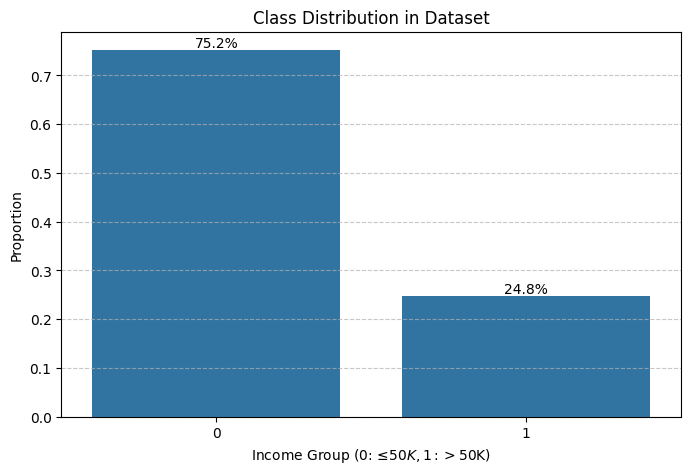

In [22]:
# Check class distribution in the dataset
class_distribution = y.value_counts(normalize=True)
print(f"Class distribution in dataset:\n{class_distribution}")
plt.figure(figsize=(8, 5)) # Create a bar plot of the class distribution
ax = sns.barplot(x=class_distribution.index, y=class_distribution.values)
plt.title('Class Distribution in Dataset')
plt.xlabel('Income Group (0: ≤$50K, 1: >$50K)')
plt.ylabel('Proportion')
for i, p in enumerate(ax.patches): # Add percentage labels on top of the bars
    height = p.get_height()
    ax.annotate(f'{height:.1%}', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [23]:
# Calculate imbalance ratio
majority_class = class_distribution.max()
minority_class = class_distribution.min()
imbalance_ratio = majority_class / minority_class
print(f"Imbalance ratio (majority:minority) => {imbalance_ratio:.2f}:1")

Imbalance ratio (majority:minority) => 3.03:1


### Handling Class Imbalance

In [24]:
# Since our dataset has an imbalance we'll calculate class weights to ensure the model pays sufficient attention to the minority class during training.
y_train_series = pd.Series(y_train)
class_counts = y_train_series.value_counts().sort_index()
classes = np.array(class_counts.index)  # instead of .to_list()
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_series)
class_weight_dict = dict(zip(classes, weights))
# class_weight_dict = {i: weight for i, weight in enumerate(len(y_train) / (len(np.unique(y_train)) * np.bincount(y_train)))}
print(f"\nClass weights for model training:\n{class_weight_dict}")


Class weights for model training:
{np.int64(0): np.float64(0.6647495498144133), np.int64(1): np.float64(2.0174548293553425)}


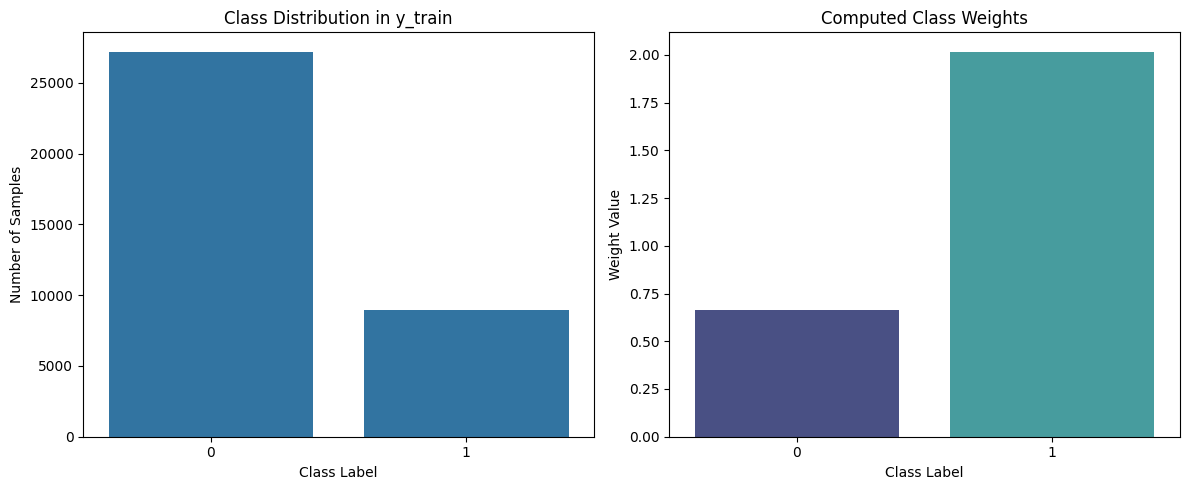

In [25]:
# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Class Distribution
sns.barplot(x=class_counts.index, y=class_counts.values, ax=ax[0])
ax[0].set_title('Class Distribution in y_train')
ax[0].set_xlabel('Class Label')
ax[0].set_ylabel('Number of Samples')

# Plot 2: Computed Class Weights
sns.barplot(x=list(class_weight_dict.keys()), y=list(class_weight_dict.values()), ax=ax[1], palette="mako")
ax[1].set_title('Computed Class Weights')
ax[1].set_xlabel('Class Label')
ax[1].set_ylabel('Weight Value')

plt.tight_layout()
plt.show()

## Modeling Approach

In [26]:
# Initialize lists to store metrics and models
fold_metrics = []
fold_models = []

best_model = None
best_metric = -np.inf  # Initialize to very low number
best_fold_index = -1

folder_path = "ignore/fold_models" # os.makedirs("ignore/fold_models", exist_ok=True)

# If the folder exists, empty it
if os.path.exists(folder_path):
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)  # remove file or link
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)  # remove subdirectory
        except Exception as e:
            print(f'Failed to delete {file_path}. Reason: {e}')
else:
    os.makedirs(folder_path)  # create the folder if it doesn't exist


fold_historys = {}

# Configuration based on seeking high robustness and accuracy, ignoring time constraints:
number_of_folds = 10  # Use 10 folds for a robust cross-validation estimate of performance.
number_of_epochs = 300 # Set epochs high; this will be controlled by early stopping.

# KFold CV
kf = KFold(n_splits=number_of_folds, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f'\nFold {fold + 1}/{number_of_folds}')
    checkpoint_path = f'{folder_path}/fold_{fold + 1}.keras'

    # Train/Val Split
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Preprocessing
    X_fold_train_processed = preprocessor.fit_transform(X_fold_train).astype('float32')
    X_fold_val_processed = preprocessor.transform(X_fold_val).astype('float32')
    # X_test_processed = preprocessor.transform(X_test).astype('float32')

    # Model
    input_dim = X_fold_train_processed.shape[1]
    keras_model = Sequential([
        # Input-level dropout to add noise and prevent overfitting from the start
        Dropout(0.1, input_shape=(input_dim,)),

        # First Dense layer with He initialization (good for ReLU/LeakyReLU)
        # Followed by LeakyReLU to avoid dead neuron problems
        Dense(256, kernel_initializer='he_normal'),
        LeakyReLU(alpha=0.1),  # Allows small gradients when input < 0
        BatchNormalization(),  # Normalize activations to improve convergence
        Dropout(0.3),          # Dropout to reduce overfitting

        # Second Dense layer with ReLU activation
        # BatchNorm and Dropout help regularize this layer
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        # Third Dense layer, similar structure
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        # Output layer for binary classification (sigmoid outputs probability)
        Dense(1, activation='sigmoid')
    ])

    keras_model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc')]
    )
    early_stopping = EarlyStopping(
        monitor='val_auc',
        patience=15,
        min_delta=0.001,  # minimum improvement threshold
        mode='max',
        restore_best_weights=True,
        verbose=1
    )


    model_checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_auc',  # track AUC for model selection
        mode='max',
        save_best_only=True,
        verbose=0
    )

    history = keras_model.fit(
        X_fold_train_processed, y_fold_train,
        validation_data=(X_fold_val_processed, y_fold_val),
        epochs=number_of_epochs,
        batch_size=64,
        class_weight=class_weight_dict,
        callbacks=[early_stopping, model_checkpoint], # Save the best model based on AUC
        verbose=0,
        shuffle=True # Shuffle the training data for each epoch
    )

    fold_historys[fold + 1] = history.history

    # Evaluation
    _, accuracy, precision, recall, auc = keras_model.evaluate(X_fold_val_processed, y_fold_val, verbose=0)
    
    # Store results
    fold_metrics.append({
        'fold': fold + 1,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'auc': auc
    })
    
    fold_models.append(keras_model)

    print(f'Fold {fold + 1} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, '
          f'Recall: {recall:.4f}, AUC: {auc:.4f}')

    # Track best model by AUC
    if auc > best_metric:
        best_metric = auc
        best_model = keras_model
        best_fold_index = fold + 1


Fold 1/10
Epoch 19: early stopping
Restoring model weights from the end of the best epoch: 4.
Fold 1 - Accuracy: 0.7797, Precision: 0.5371, Recall: 0.8573, AUC: 0.8879

Fold 2/10
Epoch 18: early stopping
Restoring model weights from the end of the best epoch: 3.
Fold 2 - Accuracy: 0.7767, Precision: 0.5315, Recall: 0.8633, AUC: 0.8841

Fold 3/10
Epoch 33: early stopping
Restoring model weights from the end of the best epoch: 18.
Fold 3 - Accuracy: 0.7814, Precision: 0.5398, Recall: 0.8733, AUC: 0.8951

Fold 4/10
Epoch 25: early stopping
Restoring model weights from the end of the best epoch: 10.
Fold 4 - Accuracy: 0.7714, Precision: 0.5120, Recall: 0.8677, AUC: 0.8888

Fold 5/10
Epoch 22: early stopping
Restoring model weights from the end of the best epoch: 7.
Fold 5 - Accuracy: 0.7836, Precision: 0.5440, Recall: 0.8750, AUC: 0.8943

Fold 6/10
Epoch 29: early stopping
Restoring model weights from the end of the best epoch: 14.
Fold 6 - Accuracy: 0.7819, Precision: 0.5392, Recall: 0.8

Fold 1 Training History


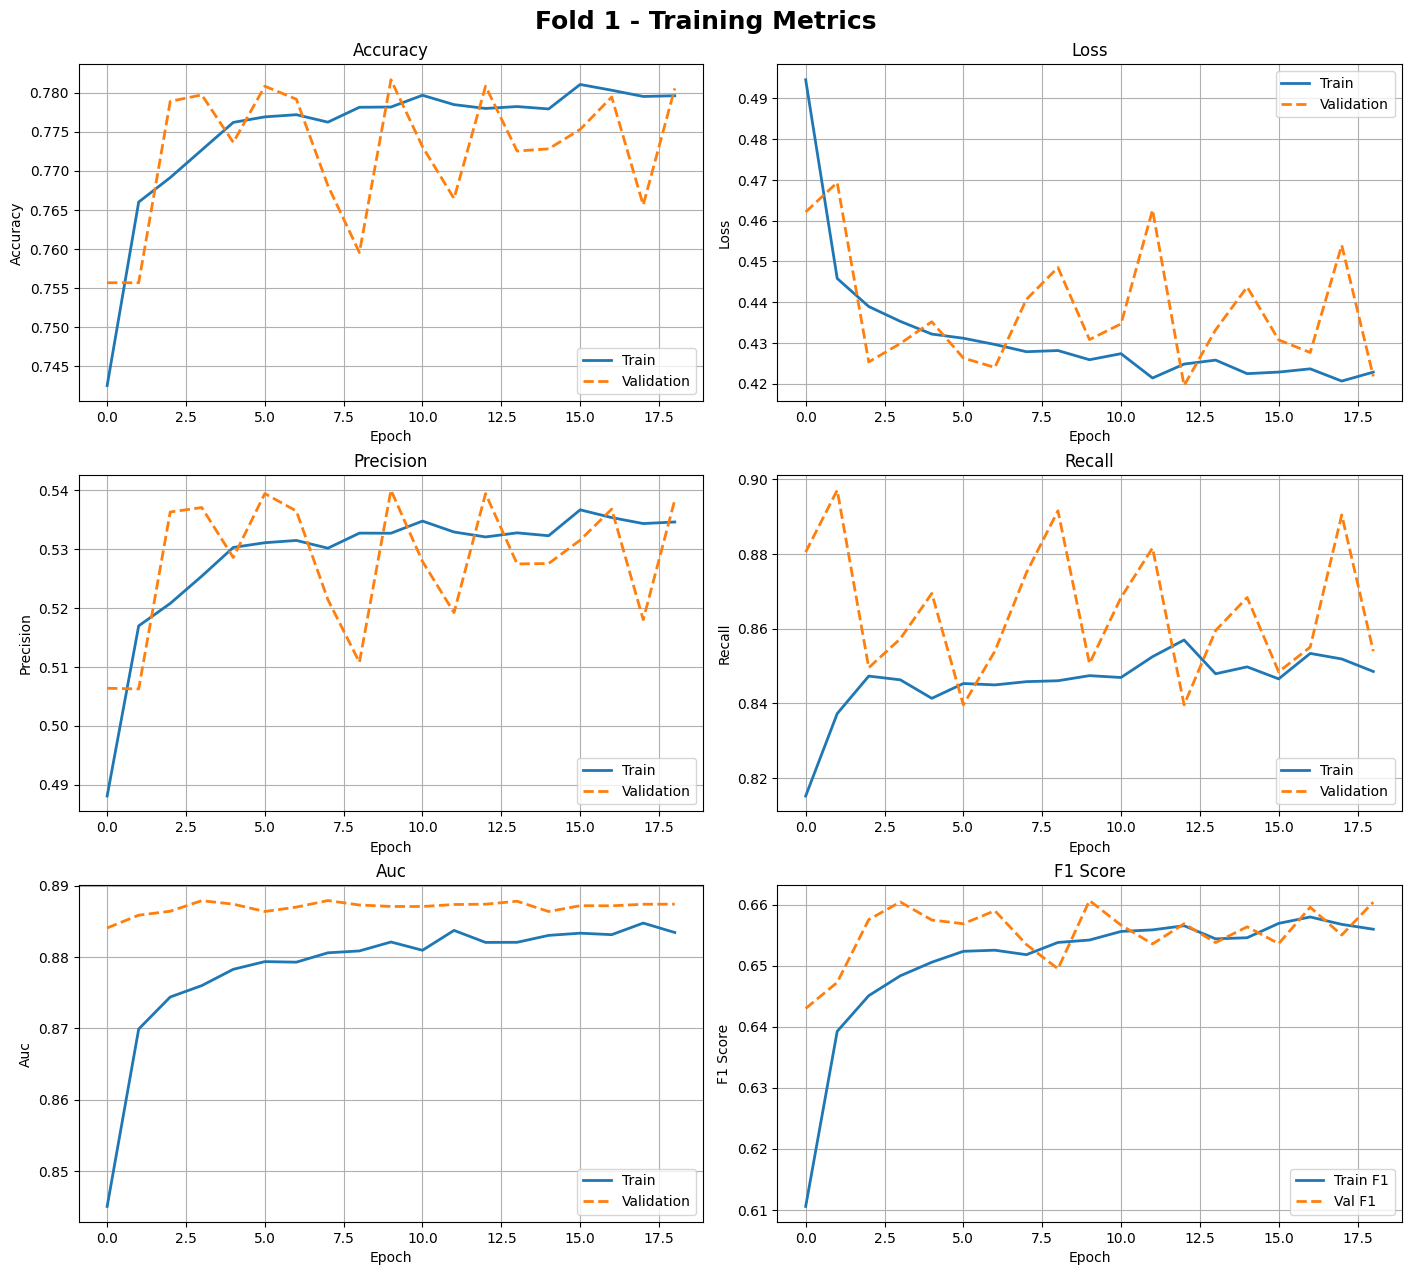

Fold 2 Training History


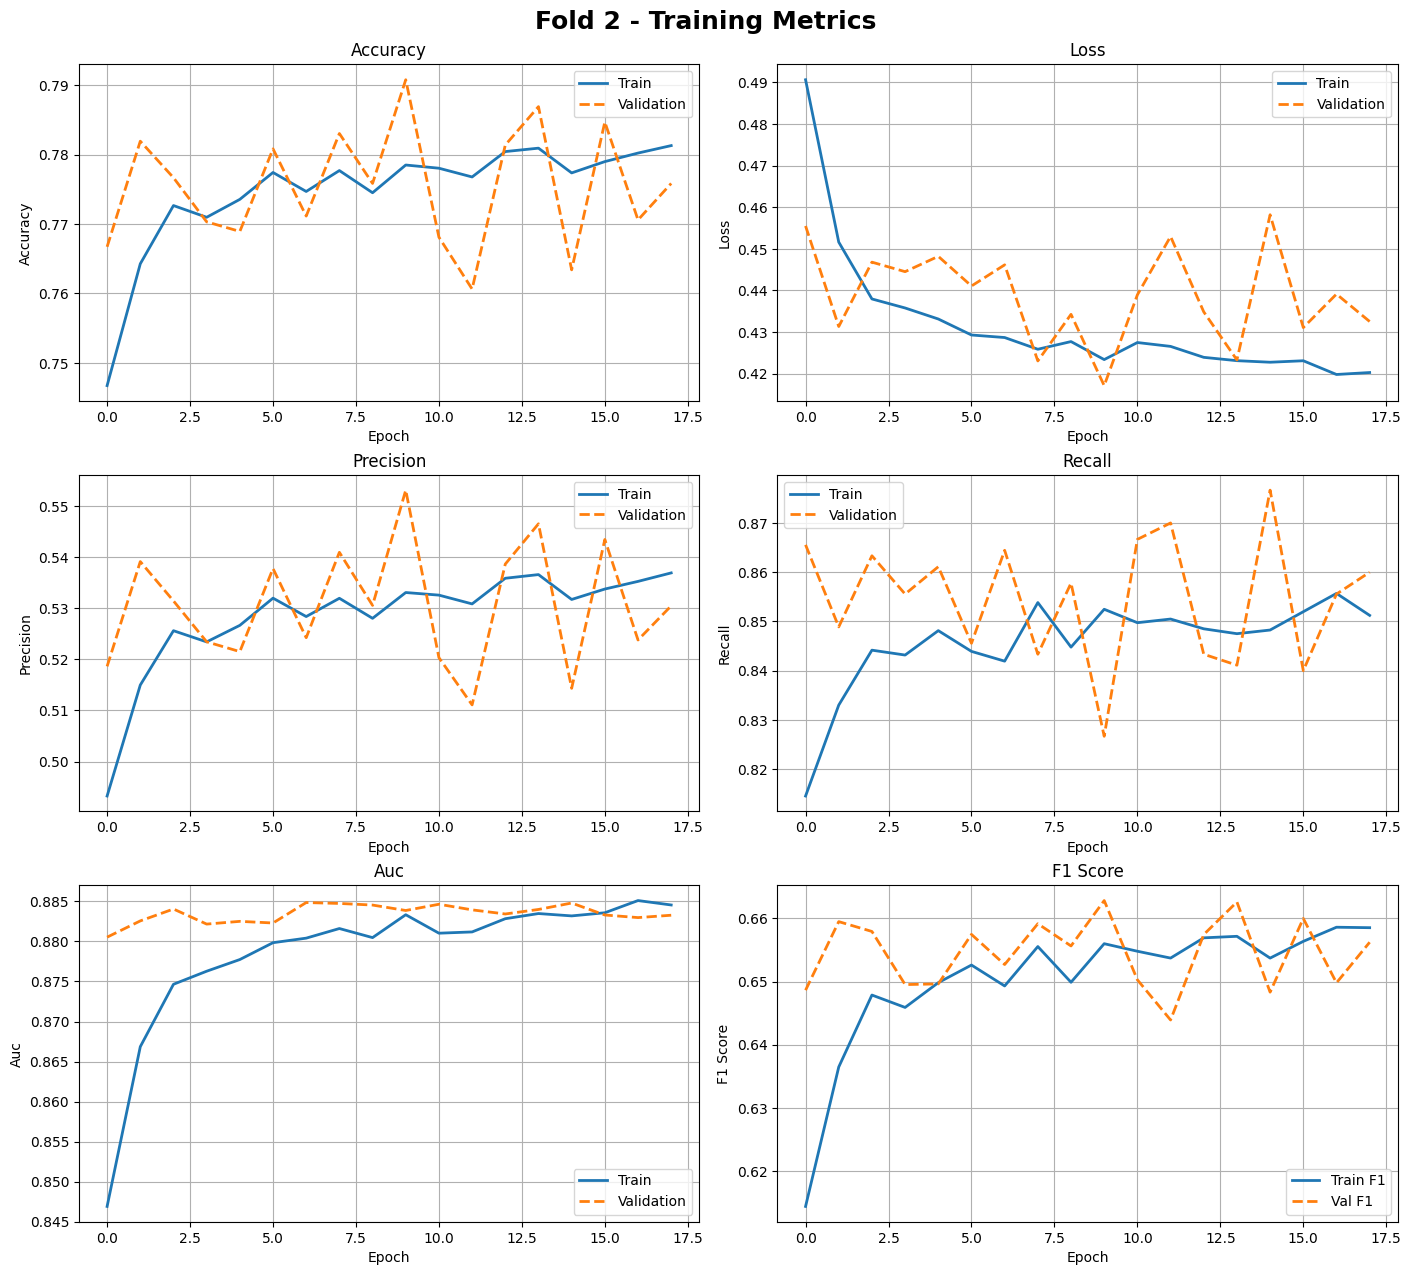

Fold 3 Training History


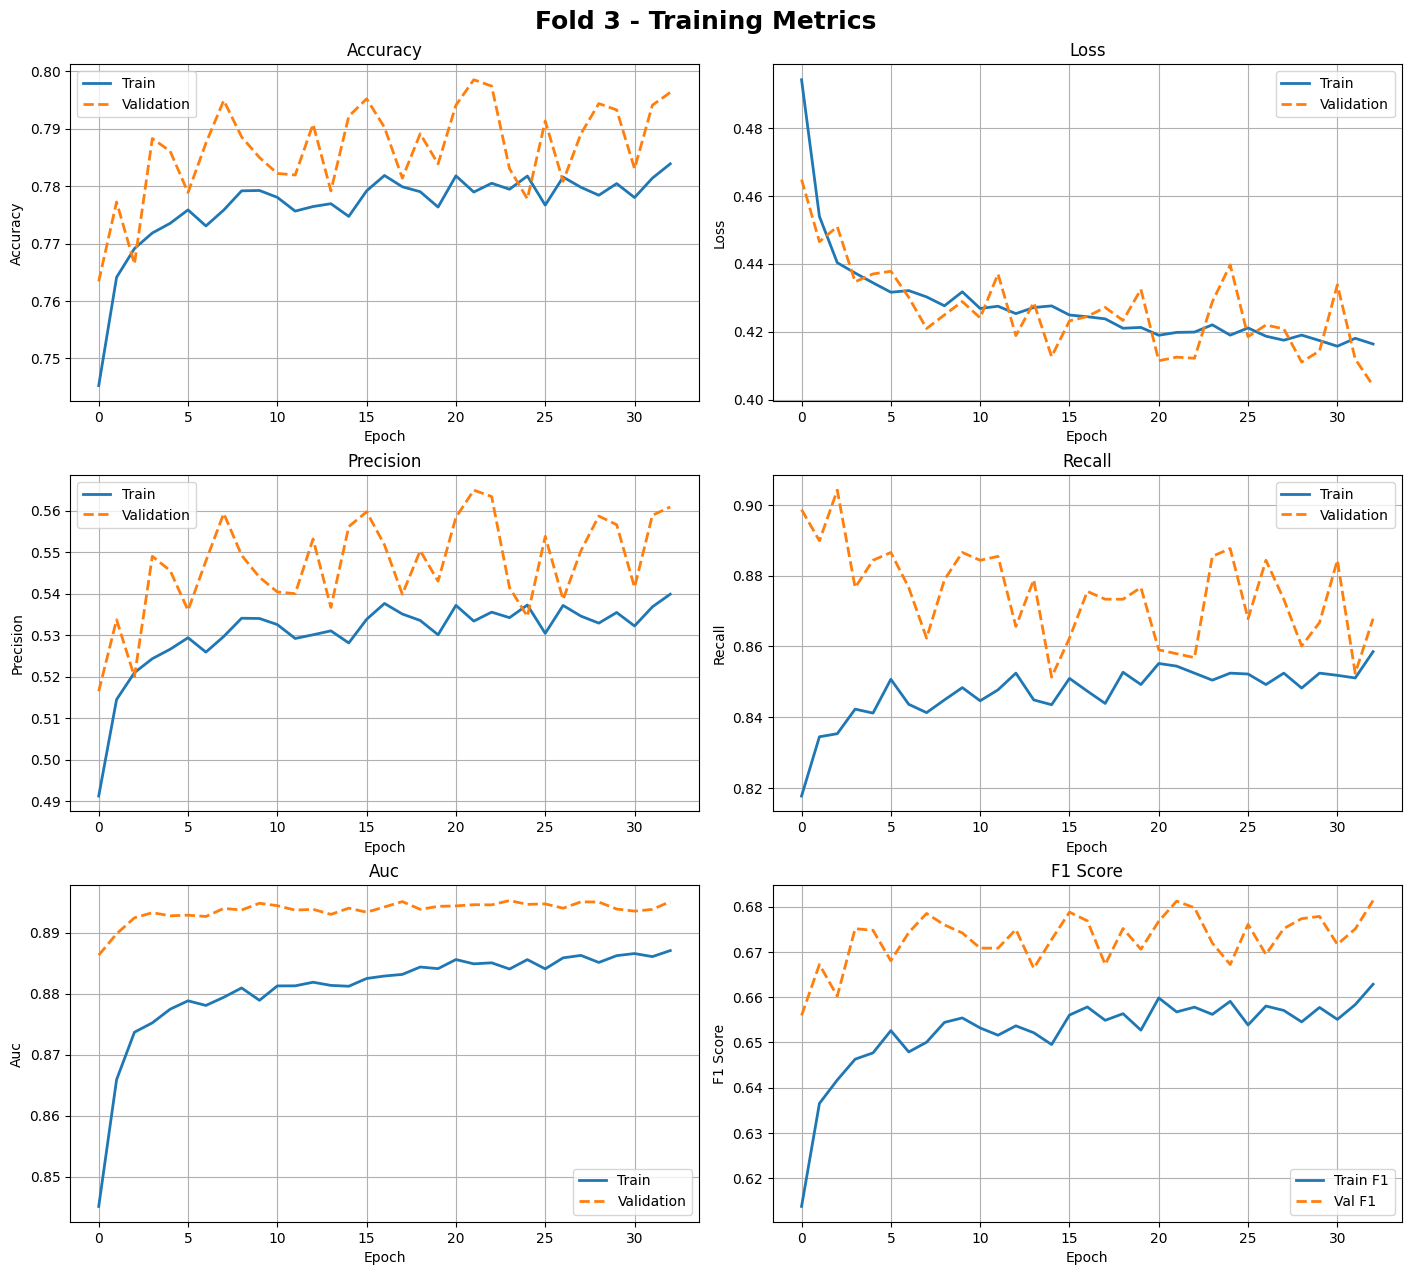

Fold 4 Training History


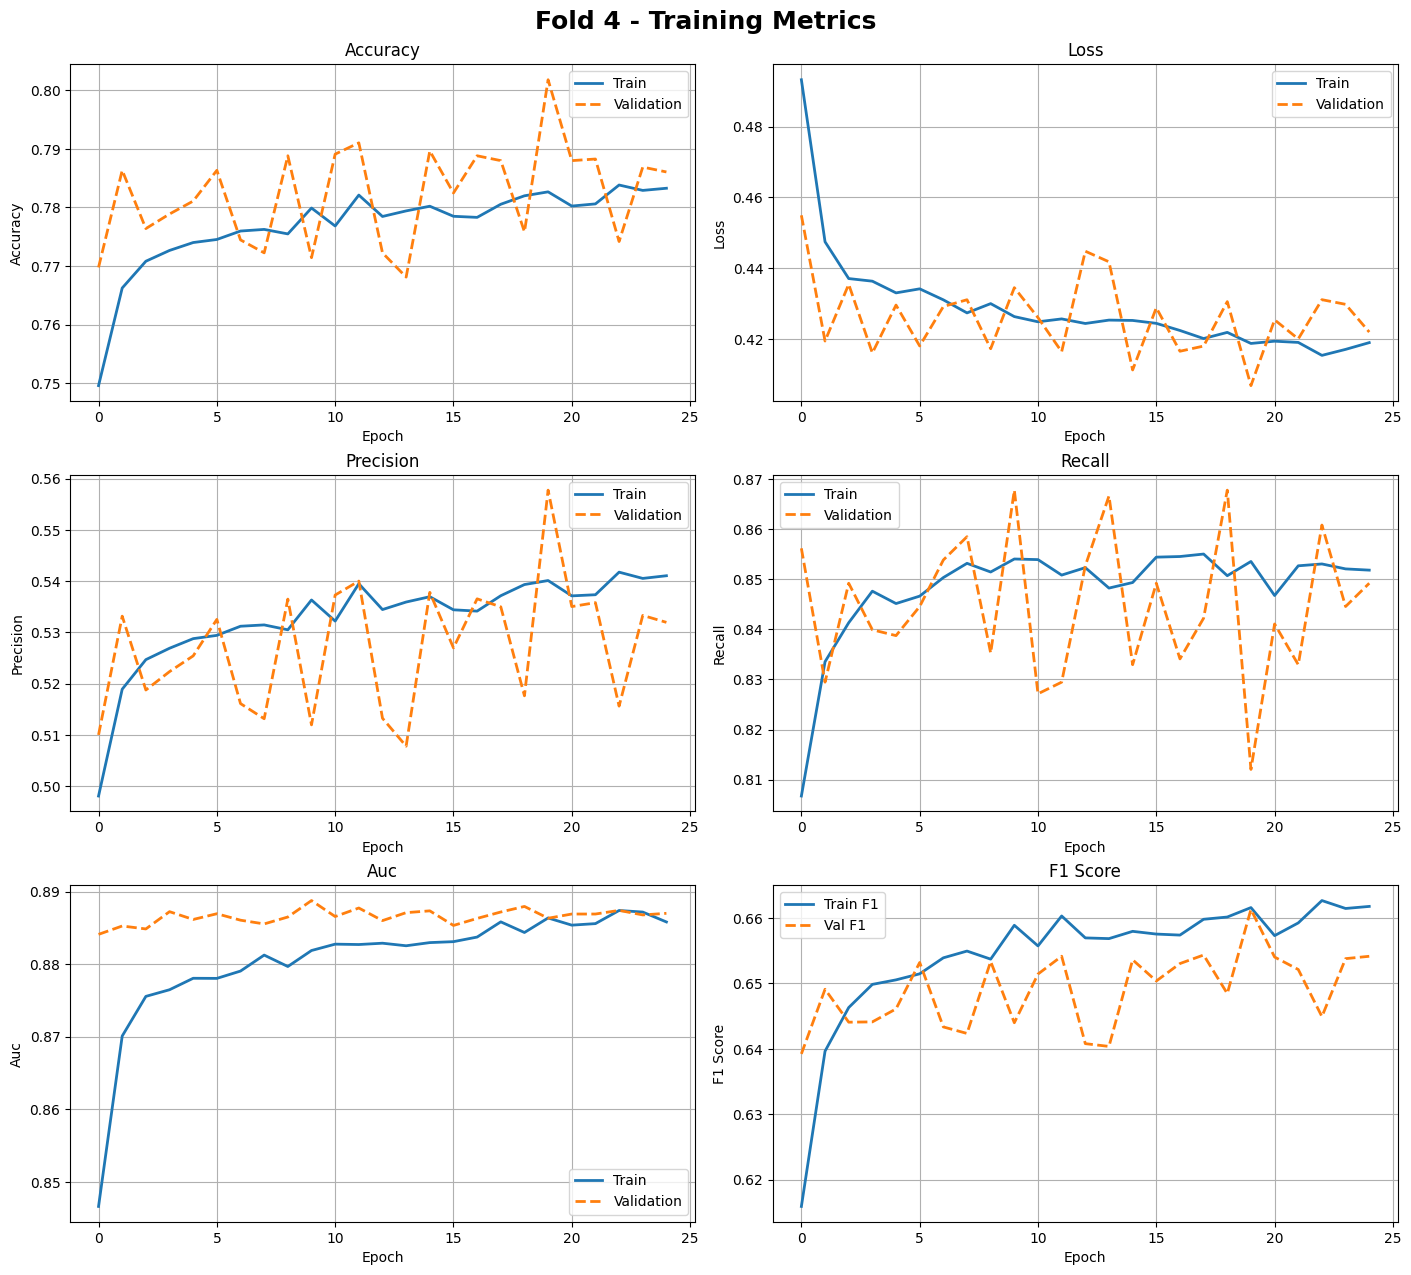

Fold 5 Training History


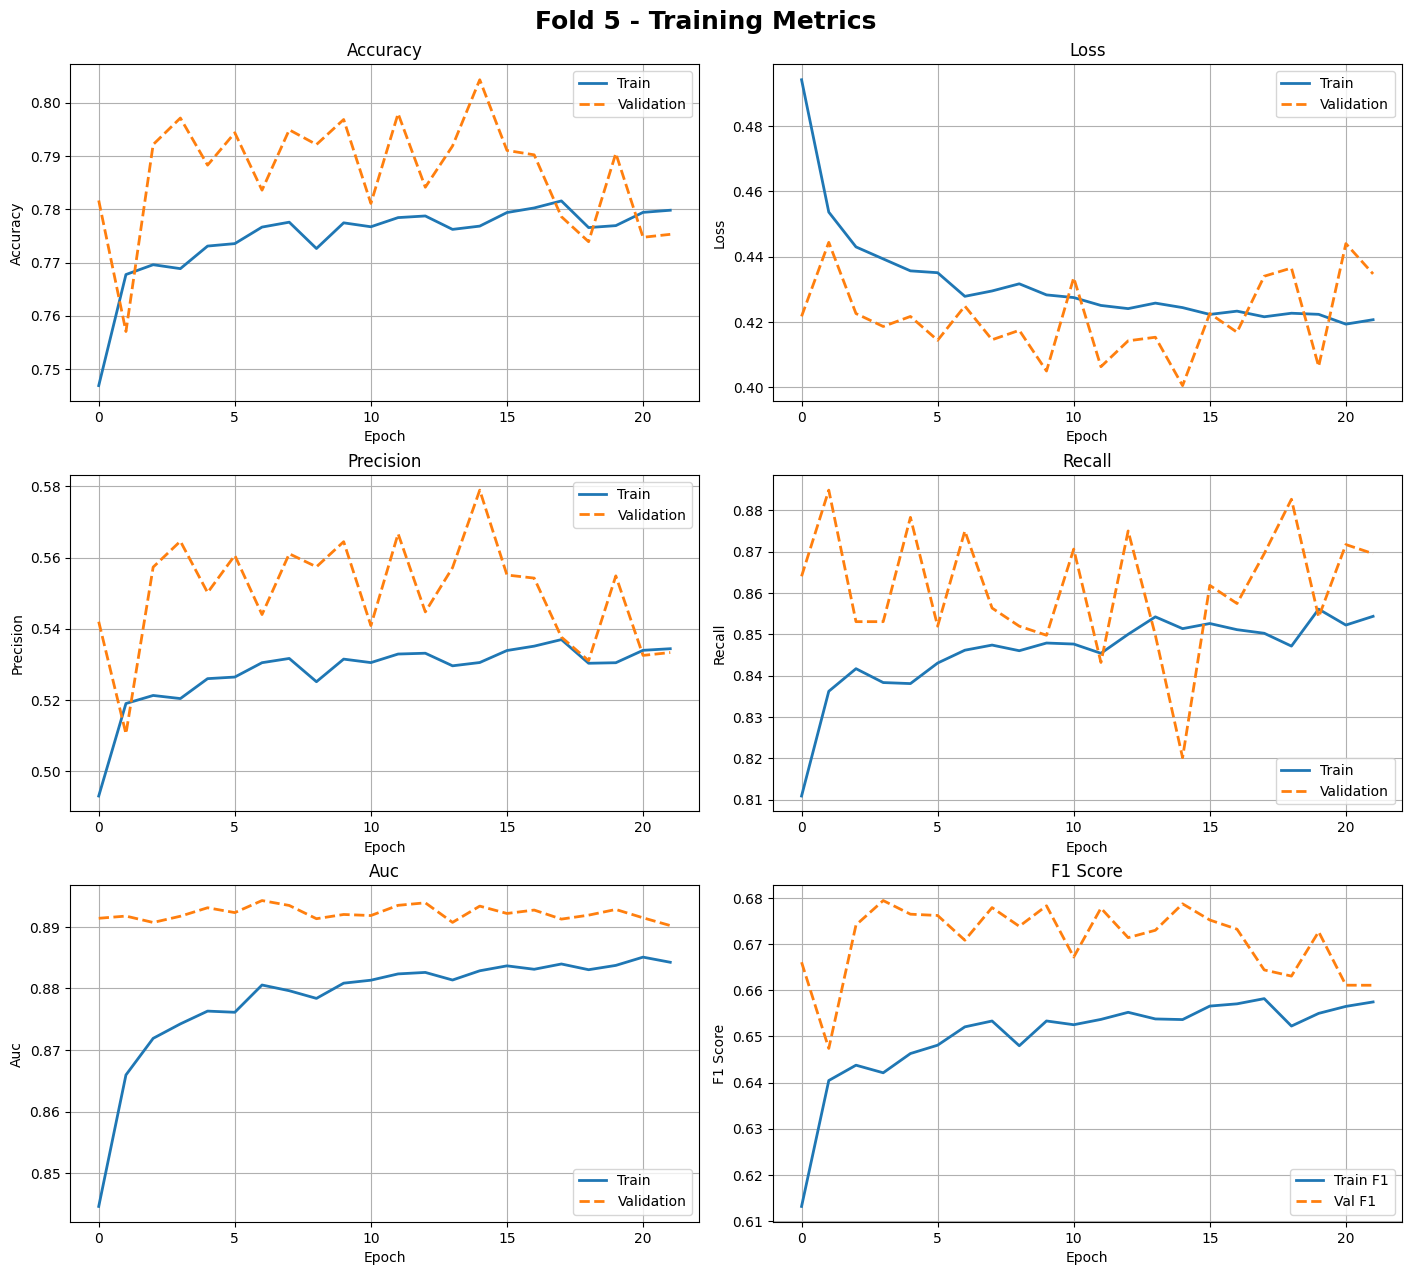

Fold 6 Training History


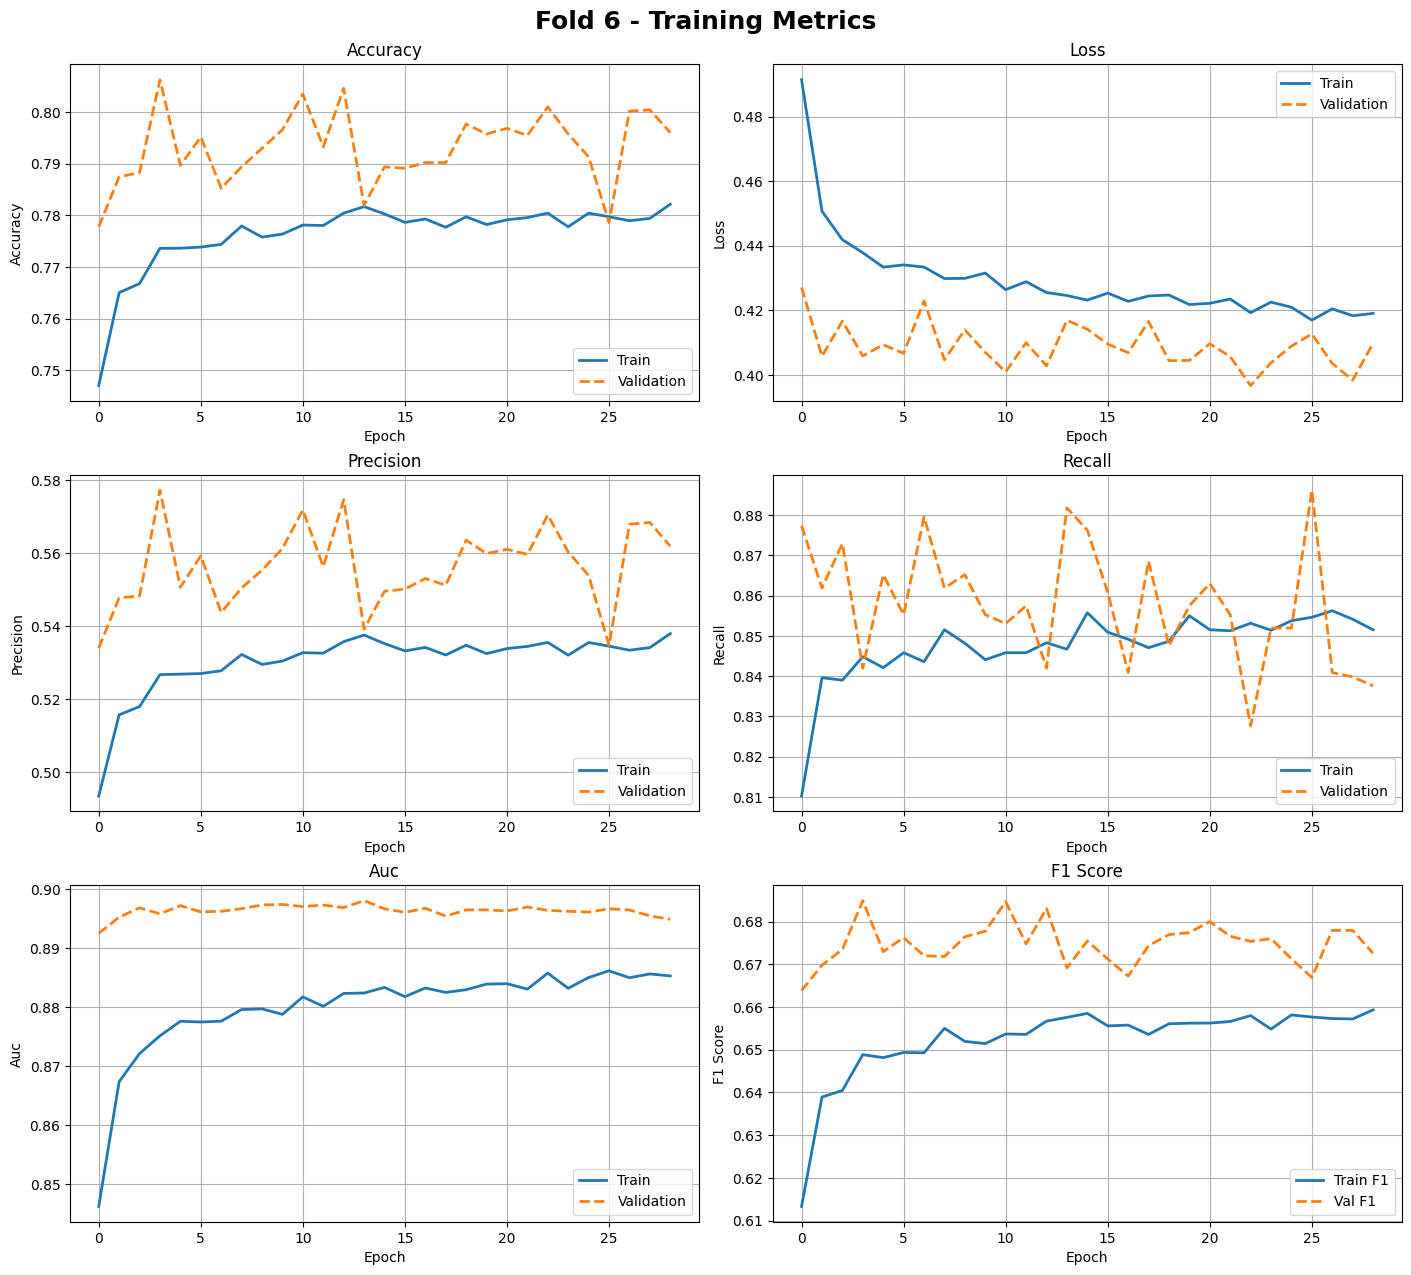

Fold 7 Training History


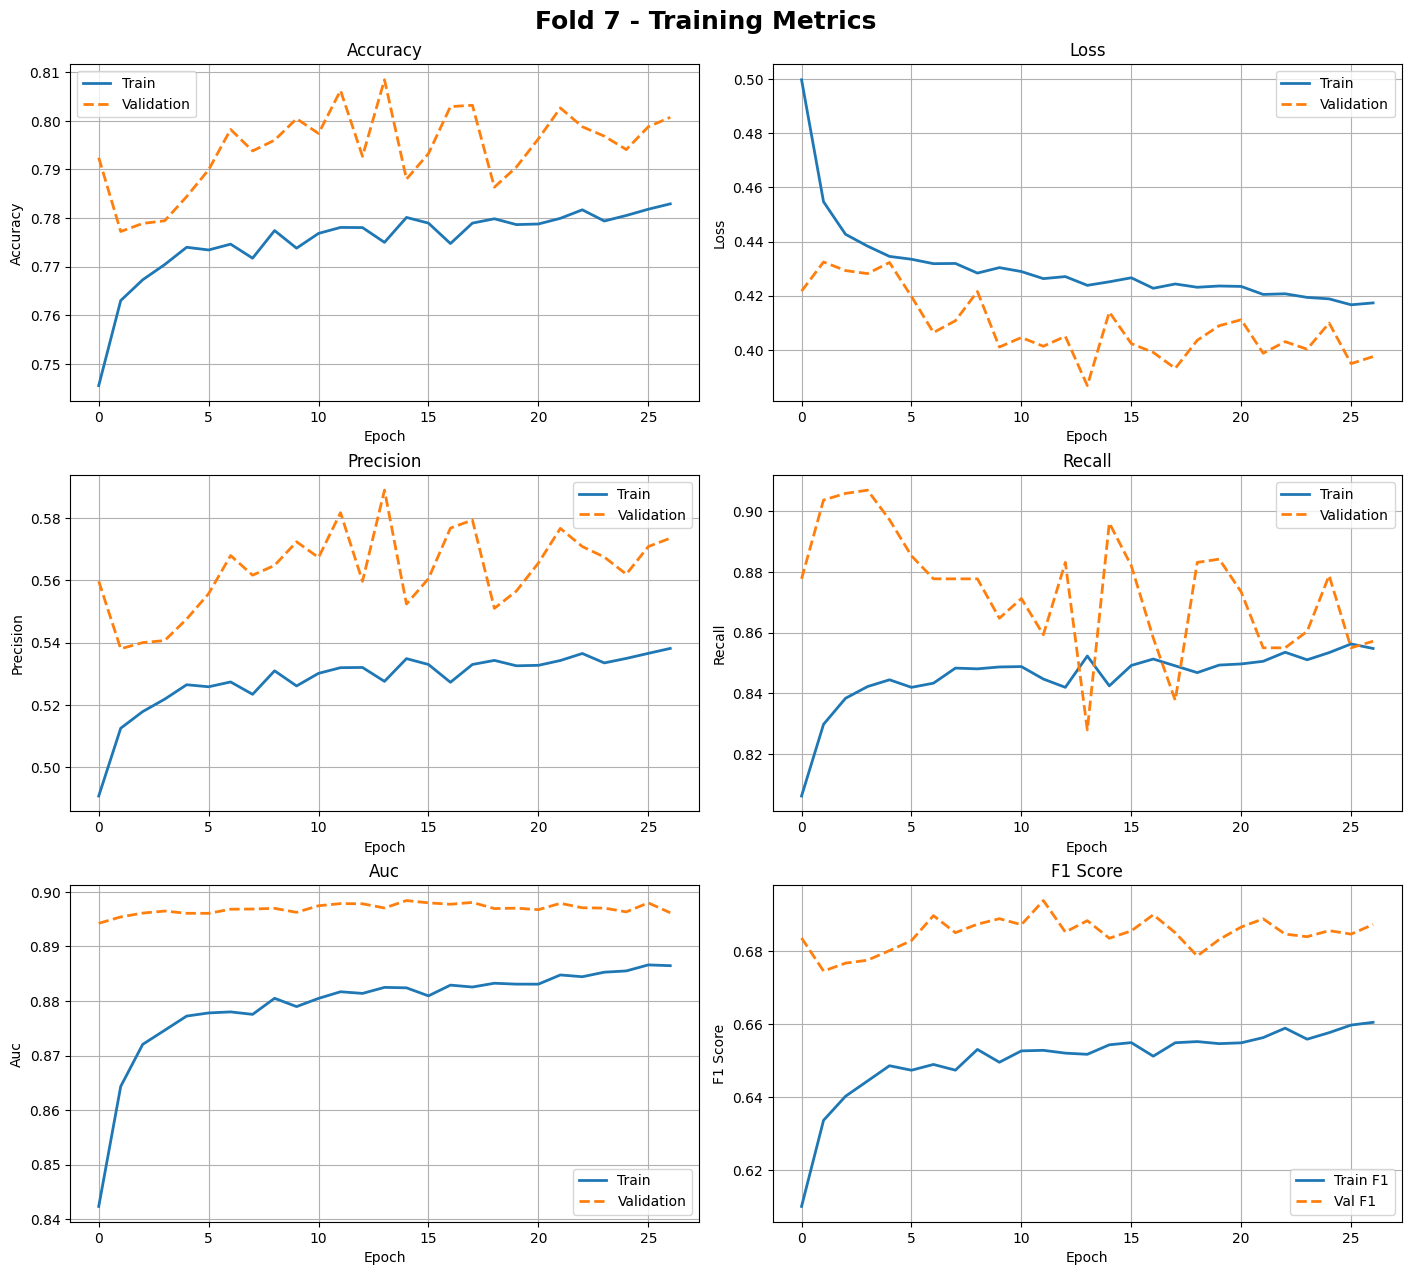

Fold 8 Training History


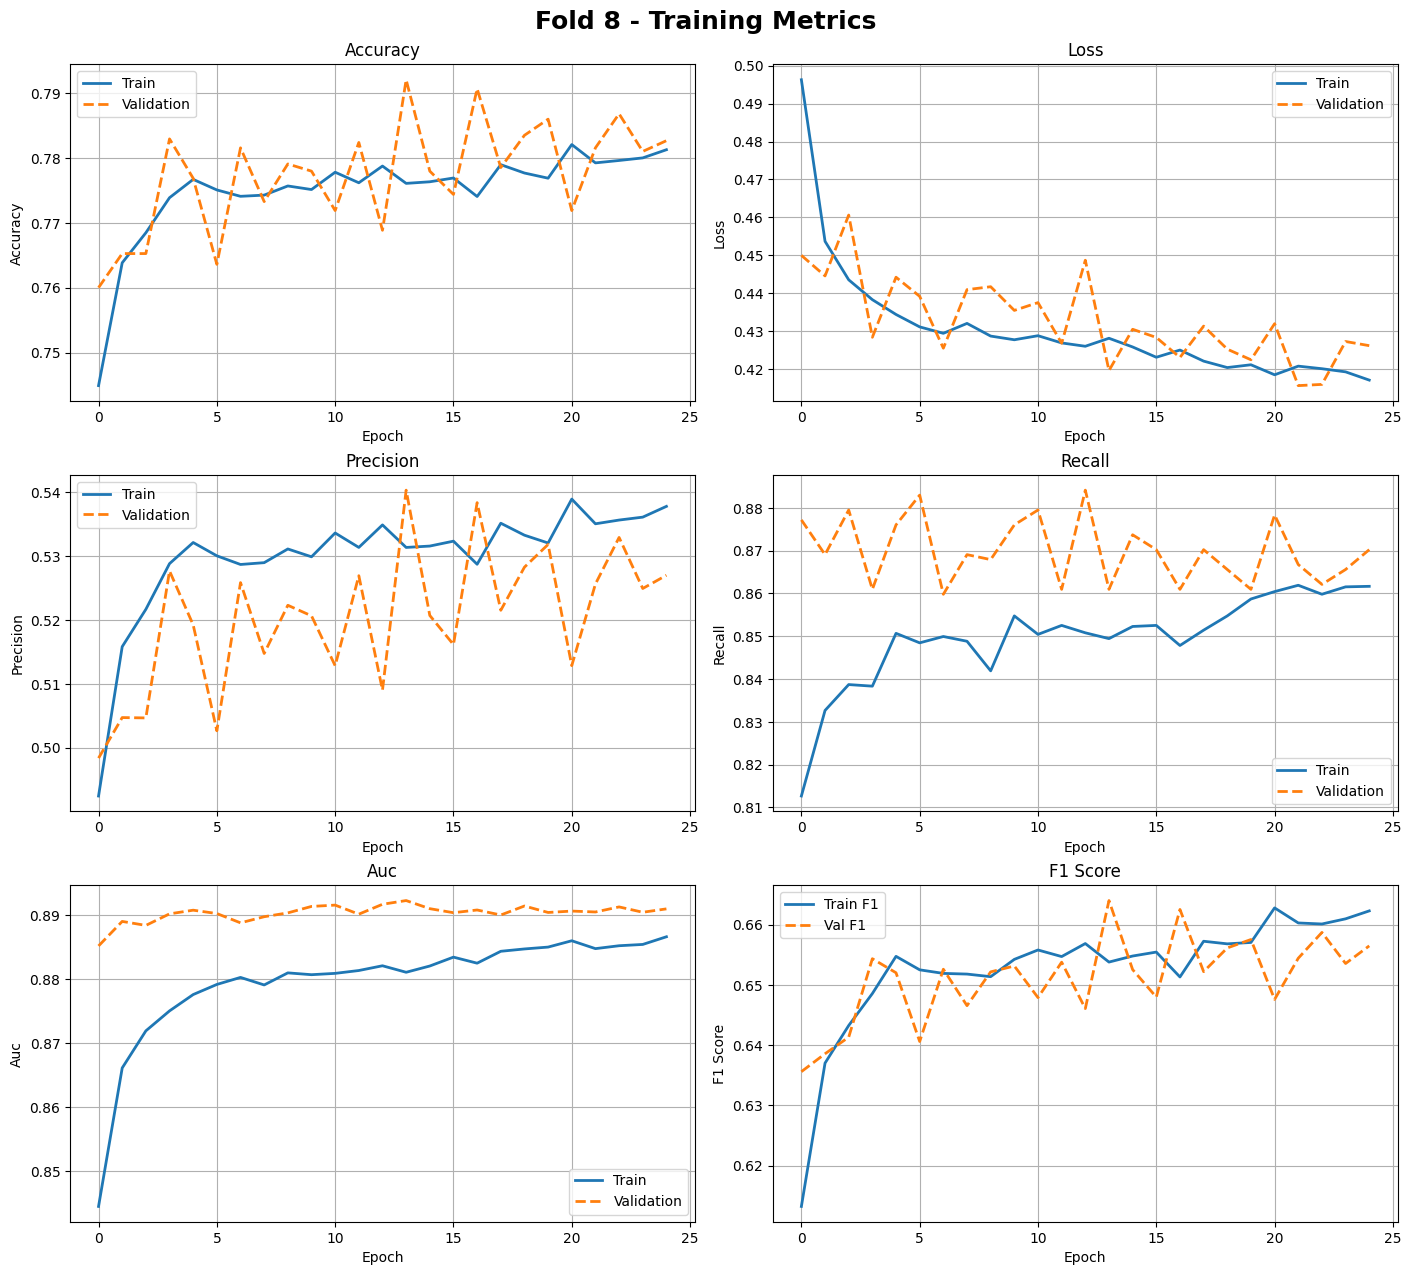

Fold 9 Training History


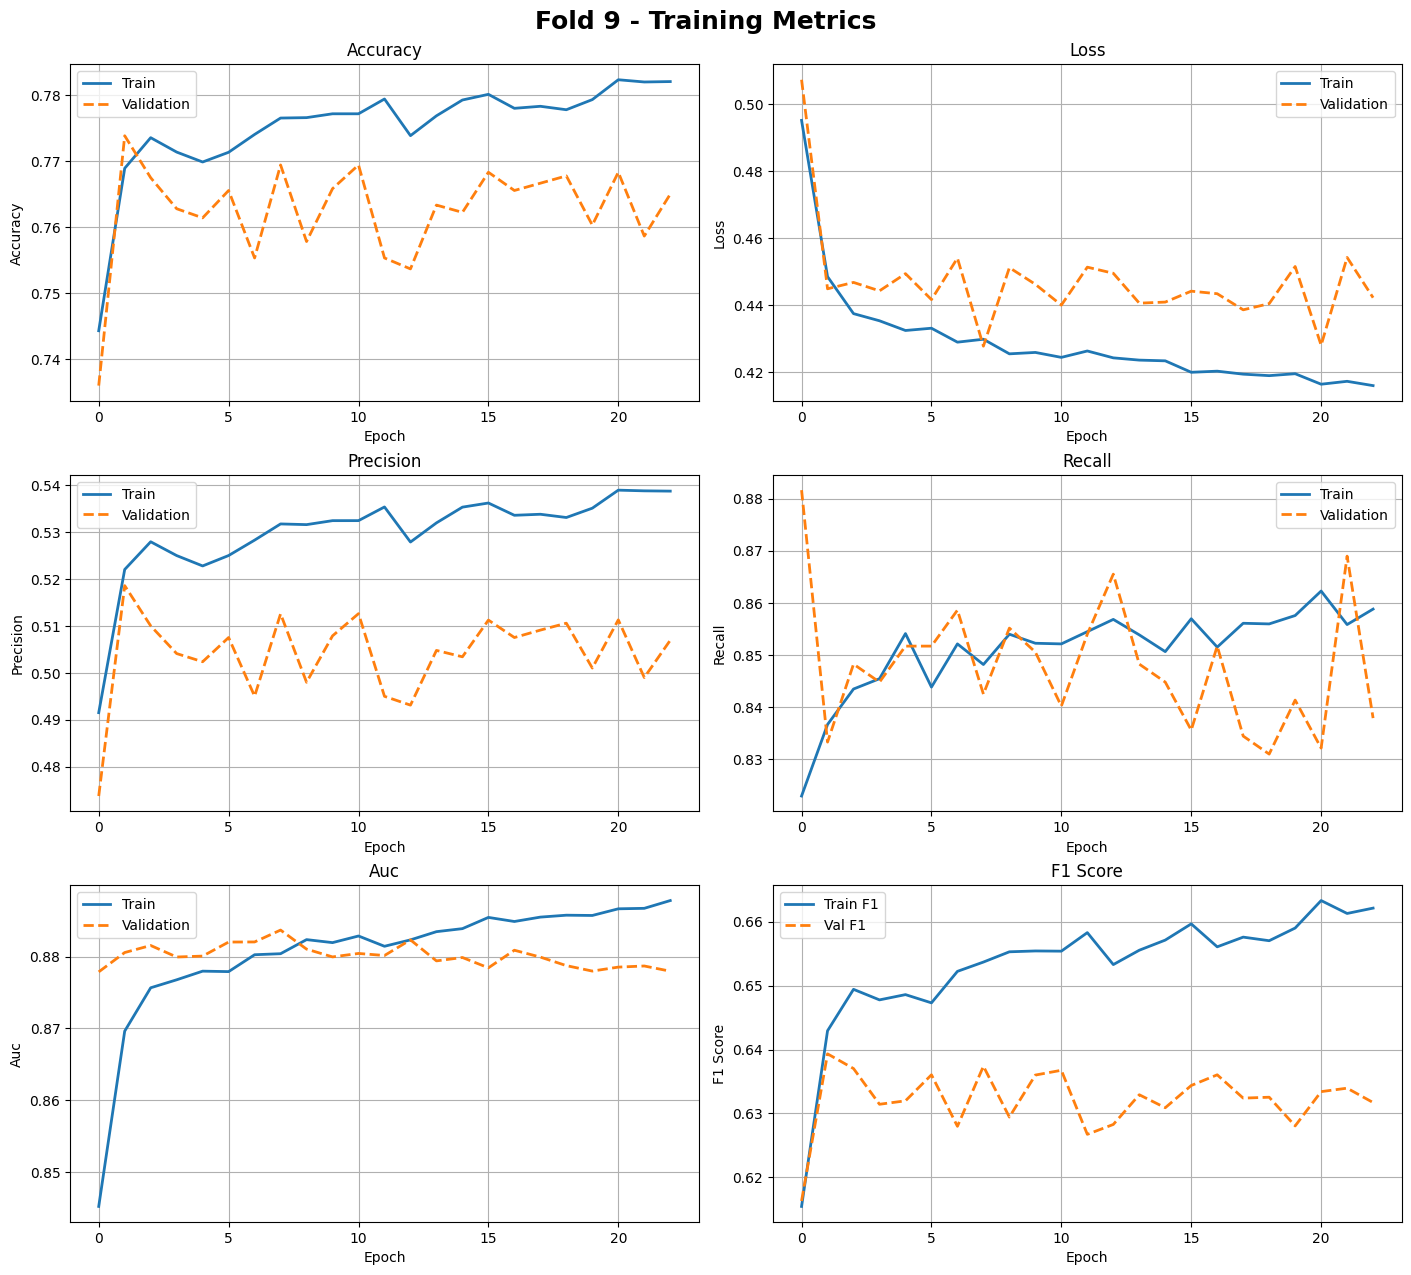

Fold 10 Training History


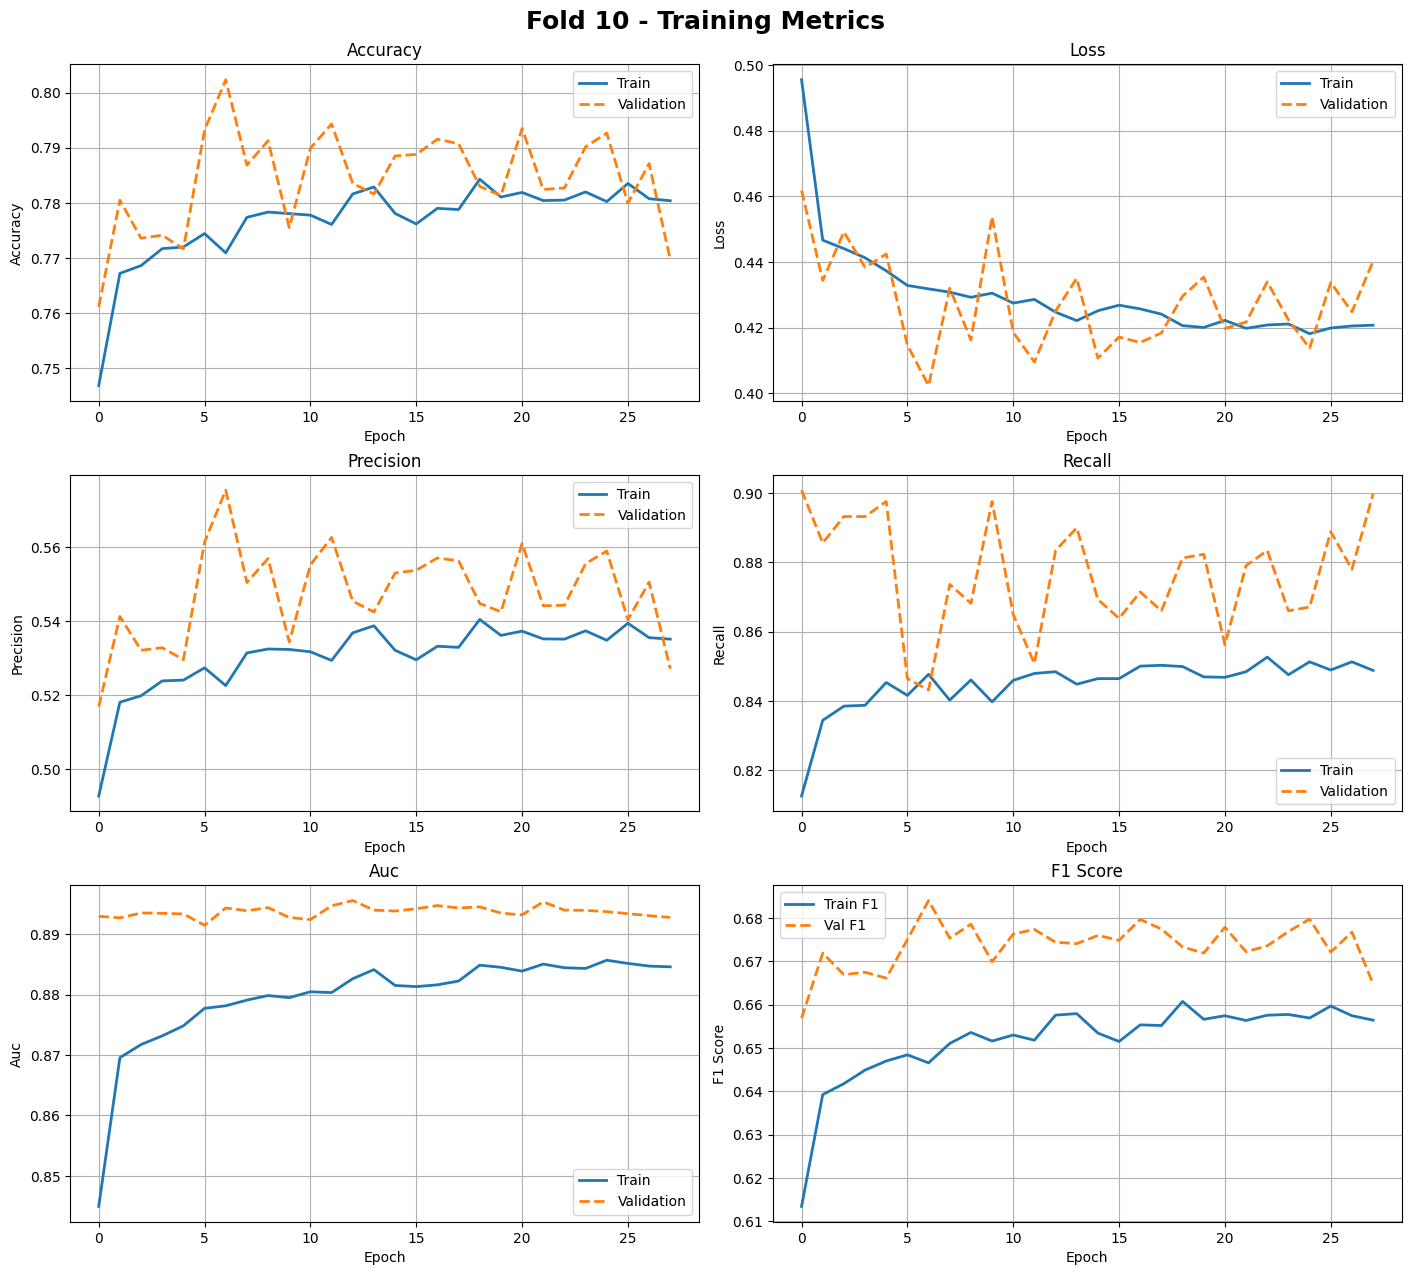

In [ ]:
def compute_f1(precision, recall):
    return [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precision, recall)]

for fold_num, history in fold_historys.items():
    print(f"Fold {fold_num} Training History")

    fig = plt.figure(figsize=(14, 16), constrained_layout=True)
    gs = fig.add_gridspec(4, 2)

    # Subplots for rows 1 to 3
    ax_accuracy = fig.add_subplot(gs[0, 0])
    ax_loss = fig.add_subplot(gs[0, 1])
    ax_precision = fig.add_subplot(gs[1, 0])
    ax_recall = fig.add_subplot(gs[1, 1])
    ax_auc = fig.add_subplot(gs[2, 0])
    ax_f1 = fig.add_subplot(gs[2, 1])
    # ax_gap = fig.add_subplot(gs[3, 0])      # ← Row 4 (AUC Gap) - Commented
    # ax_lr = fig.add_subplot(gs[3, 1])       # ← Row 4 (Learning Rate) - Commented

    # Standard metric plots
    base_metrics = [
        ('accuracy', ax_accuracy),
        ('loss', ax_loss),
        ('precision', ax_precision),
        ('recall', ax_recall),
        ('auc', ax_auc),
    ]

    for metric, ax in base_metrics:
        ax.plot(history[metric], label='Train', linewidth=2)
        ax.plot(history[f'val_{metric}'], label='Validation', linestyle='--', linewidth=2)
        ax.set_title(f'{metric.title()}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric.title())
        ax.legend()
        ax.grid(True)

    # F1 Score plot
    train_f1 = compute_f1(history['precision'], history['recall'])
    val_f1 = compute_f1(history['val_precision'], history['val_recall'])
    ax_f1.plot(train_f1, label='Train F1', linewidth=2)
    ax_f1.plot(val_f1, label='Val F1', linestyle='--', linewidth=2)
    ax_f1.set_title('F1 Score')
    ax_f1.set_xlabel('Epoch')
    ax_f1.set_ylabel('F1 Score')
    ax_f1.legend()
    ax_f1.grid(True)

    # AUC Gap Plot
    # auc_gap = [tr - val for tr, val in zip(history['auc'], history['val_auc'])]
    # ax_gap.plot(auc_gap, color='orange', label='AUC Gap (Train - Val)', linewidth=2)
    # ax_gap.axhline(0, color='gray', linestyle='--')
    # ax_gap.set_title('AUC Gap')
    # ax_gap.set_xlabel('Epoch')
    # ax_gap.set_ylabel('Gap')
    # ax_gap.legend()
    # ax_gap.grid(True)

    # Learning Rate Plot
    # if 'lr' in history:
    #     ax_lr.plot(history['lr'], label='Learning Rate', color='purple', linewidth=2)
    #     ax_lr.set_title('Learning Rate')
    #     ax_lr.set_xlabel('Epoch')
    #     ax_lr.set_ylabel('LR')
    #     ax_lr.legend()
    #     ax_lr.grid(True)
    # else:
    #     ax_lr.text(0.5, 0.5, 'No LR Data', ha='center', va='center', fontsize=12)
    #     ax_lr.set_title('Learning Rate')
    #     ax_lr.axis('off')

    fig.suptitle(f'Fold {fold_num} - Training Metrics', fontsize=18, fontweight='bold')
    plt.show()

In [28]:
# Average metrics
avg_metrics = {
    metric: np.mean([fold[metric] for fold in fold_metrics])
    for metric in ['accuracy', 'precision', 'recall', 'auc']
}

print('\nAverage metrics across all folds:')
print(f"Accuracy: {avg_metrics['accuracy']:.4f}")
print(f"Precision: {avg_metrics['precision']:.4f}")
print(f"Recall: {avg_metrics['recall']:.4f}")
print(f"AUC: {avg_metrics['auc']:.4f}")


Average metrics across all folds:
Accuracy: 0.7812
Precision: 0.5364
Recall: 0.8680
AUC: 0.8917


## Evaluation & Results

### Cross-Validation Performance

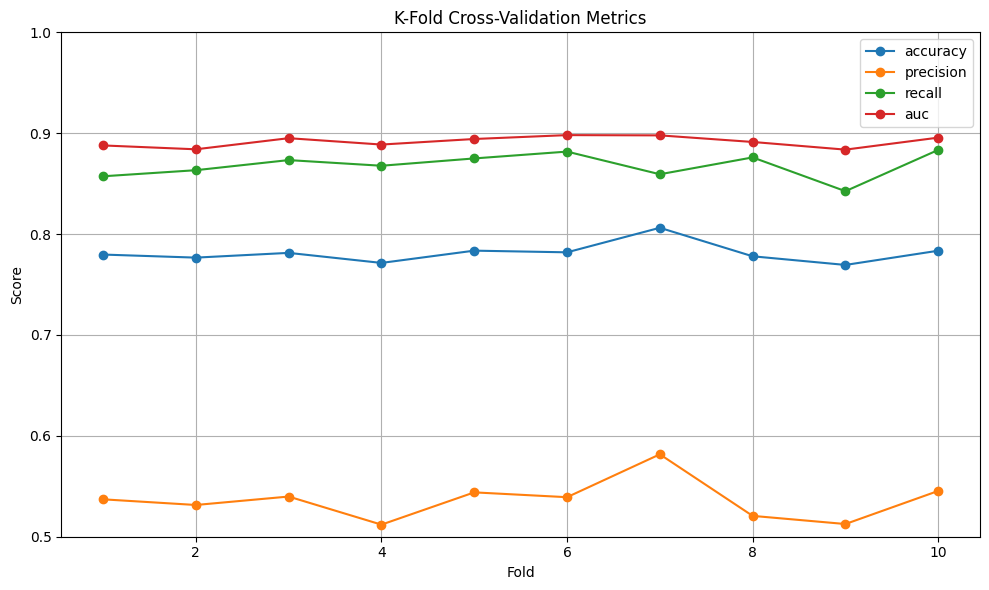

In [29]:
df_metrics = pd.DataFrame(fold_metrics) # Convert to DataFrame
plt.figure(figsize=(10, 6))# Plotting
# df_metrics.plot(x='fold', y=['accuracy', 'precision', 'recall', 'auc'], kind='bar', figsize=(10, 5))
for metric in ['accuracy', 'precision', 'recall', 'auc']:
    plt.plot(df_metrics['fold'], df_metrics[metric], marker='o', label=metric)
plt.title('K-Fold Cross-Validation Metrics') # plt.title('Fold-wise Evaluation Metrics')
plt.xlabel('Fold')
plt.ylabel('Score')
# plt.xticks(rotation=0)
plt.ylim(0.5, 1.0)
plt.grid(True) # plt.grid(axis='y')
plt.legend()
plt.tight_layout()
plt.show()

In [30]:
# Report best fold
print(f"\nBest Model is from Fold {best_fold_index} with AUC: {best_metric:.4f}")
best_model_path = f'{folder_path}/fold_{best_fold_index}.keras'
final_model = load_model(best_model_path)
# final_model.save('ignore/best_model_overall.keras')


Best Model is from Fold 6 with AUC: 0.8981


### Model Architecture Summary

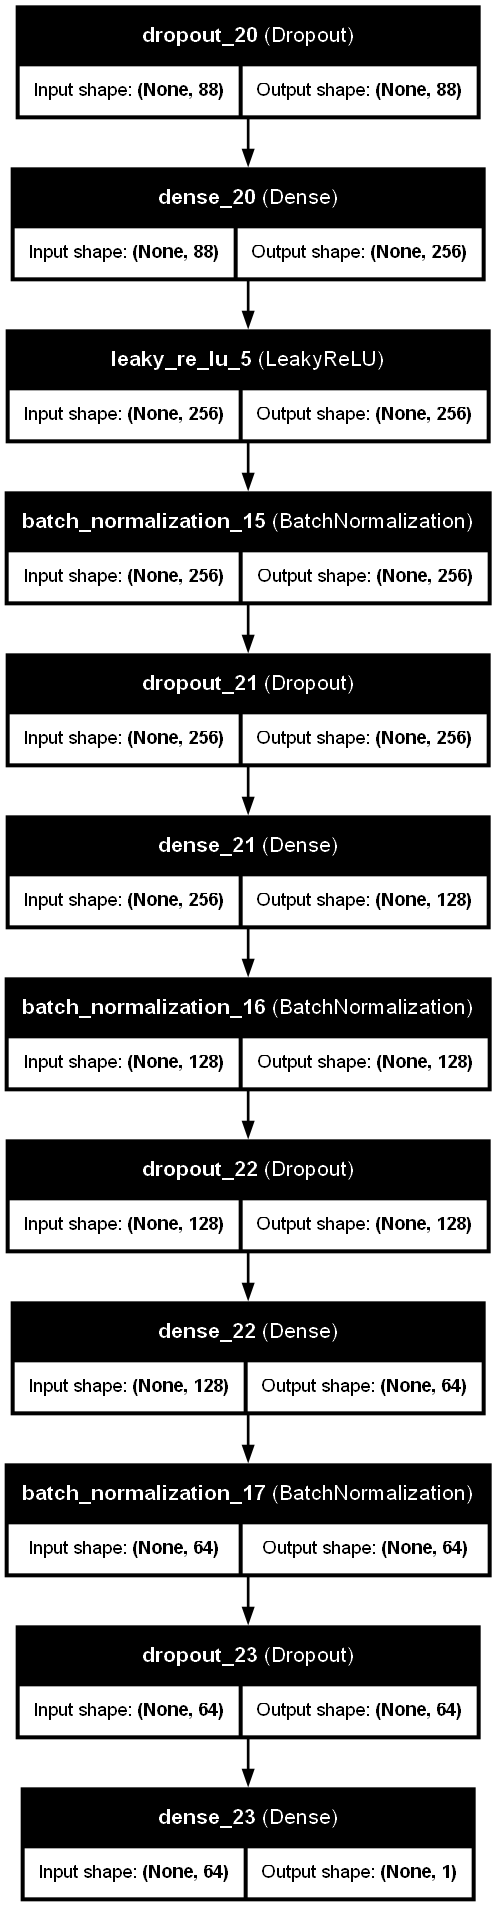

In [31]:
plot_model(
    final_model,
    to_file='ignore/model_plot.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96
)

In [32]:
keras_model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_36 (Dropout)            │ (None, 88)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 256)            │        22,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 195,589 (764.02 KB)

 Trainable params: 64,897 (253.50 KB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 129,796 (507.02 KB)

### Learning Curves

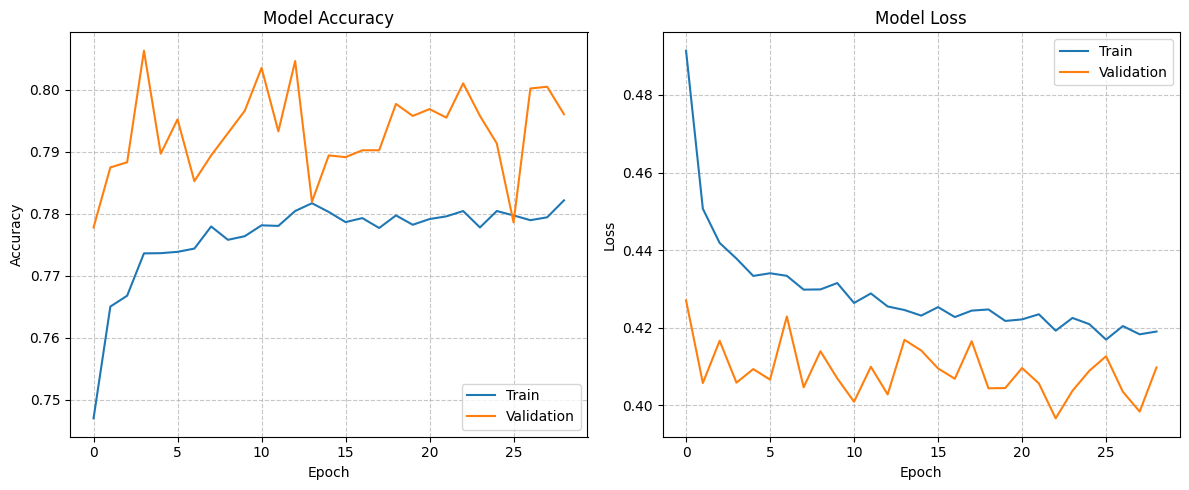

Training completed after 29 epochs
Final training loss: 0.4190
Final training accuracy: 0.7821
Final validation loss: 0.4098
Final validation accuracy: 0.7960


In [ ]:
best_history = fold_historys[best_fold_index]

# Plot learning curves
plt.figure(figsize=(12, 5))

# Plot training accuracy values
plt.subplot(1, 2, 1)
plt.plot(best_history['accuracy'], label='Train')
plt.plot(best_history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Plot training loss values
plt.subplot(1, 2, 2)
plt.plot(best_history['loss'], label='Train')
plt.plot(best_history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Print information about training
print(f"Training completed after {len(best_history['loss'])} epochs")
print(f"Final training loss: {best_history['loss'][-1]:.4f}")
print(f"Final training accuracy: {best_history['accuracy'][-1]:.4f}")
print(f"Final validation loss: {best_history['val_loss'][-1]:.4f}")
print(f"Final validation accuracy: {best_history['val_accuracy'][-1]:.4f}")

In [83]:
# Get metrics from best epoch
best_epoch = np.argmax(best_history['val_auc'])

# Validation metrics at best epoch
val_accuracy = best_history['val_accuracy'][best_epoch]
val_precision = best_history['val_precision'][best_epoch]
val_recall = best_history['val_recall'][best_epoch]
val_auc = best_history['val_auc'][best_epoch]
val_loss = best_history['val_loss'][best_epoch]
# val_f1 = 2 * (val_precision * val_recall) / (val_precision + val_recall)

print("Best Epoch for Fold Number:", best_epoch + 1, "\nFold", best_fold_index)

Best Epoch for Fold Number: 15 
Fold 6


### Final Test Set Evaluation

In [84]:
# Preprocess the test set
X_test_processed = preprocessor.transform(X_test).astype('float32')

# Predict and evaluate
y_test_pred_probs = final_model.predict(X_test_processed).flatten()
y_test_pred = (y_test_pred_probs > 0.5).astype("int32")

283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [85]:
# Get test scores
test_loss = final_model.evaluate(X_test_processed, y_test, verbose=0)[0]
test_accuracy = accuracy_score(y_test, y_test_pred) # final_model.evaluate(X_test_processed, y_test, verbose=0)[1]
test_precision = precision_score(y_test, y_test_pred) # final_model.evaluate(X_test_processed, y_test, verbose=0)[2]
test_recall = recall_score(y_test, y_test_pred) # final_model.evaluate(X_test_processed, y_test, verbose=0)[3]
test_auc = roc_auc_score(y_test, y_test_pred_probs) # final_model.evaluate(X_test_processed, y_test, verbose=0)[4]
# test_f1 = f1_score(y_test, y_test_pred)
cm = confusion_matrix(y_test, y_test_pred)
cr = classification_report(y_test, y_test_pred, output_dict=True)
cr_df = pd.DataFrame(cr).transpose()
precision, recall, thresholds = precision_recall_curve(y_test, y_test_pred_probs)
average_precision = average_precision_score(y_test, y_test_pred_probs)

In [86]:
# Metrics and their corresponding scores
metrics = ['Accuracy', 'Precision', 'Recall', 'AUC', 'Loss'] # , 'F1'
val_scores = [val_accuracy, val_precision, val_recall, val_auc, val_loss] # , val_f1
test_scores = [test_accuracy, test_precision, test_recall, test_auc, test_loss] # , test_f1

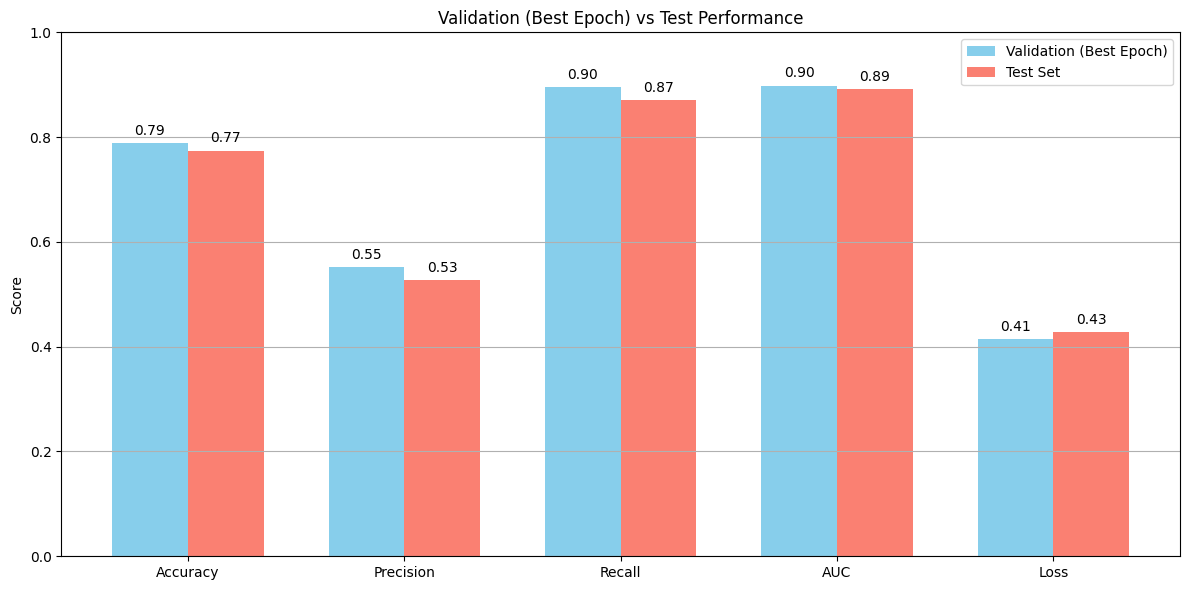

In [87]:
# Positioning and bar plot setup
x = np.arange(len(metrics))
width = 0.35
plt.figure(figsize=(12, 6))

# Plotting the bars
bars1 = plt.bar(x - width/2, val_scores, width, label='Validation (Best Epoch)', color='skyblue')
bars2 = plt.bar(x + width/2, test_scores, width, label='Test Set', color='salmon')

# Plot customization
plt.ylabel('Score')
plt.title('Validation (Best Epoch) vs Test Performance')
plt.xticks(x, metrics)
plt.ylim(0, 1 if max(max(val_scores), max(test_scores)) <= 1 else max(max(val_scores), max(test_scores)) + 0.1)
plt.legend()
plt.grid(axis='y')

# Annotate bars with values
for i in range(len(metrics)):
    plt.text(x[i] - width/2, val_scores[i] + 0.01, f"{val_scores[i]:.2f}", ha='center', va='bottom')
    plt.text(x[i] + width/2, test_scores[i] + 0.01, f"{test_scores[i]:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()


### Confusion Matrix Visualization

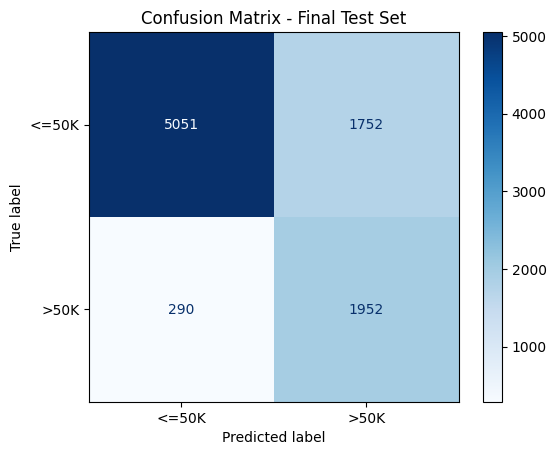

In [88]:
# Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['<=50K', '>50K'])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - Final Test Set")
plt.grid(False)
plt.show()

### Per-Class Performance Metrics

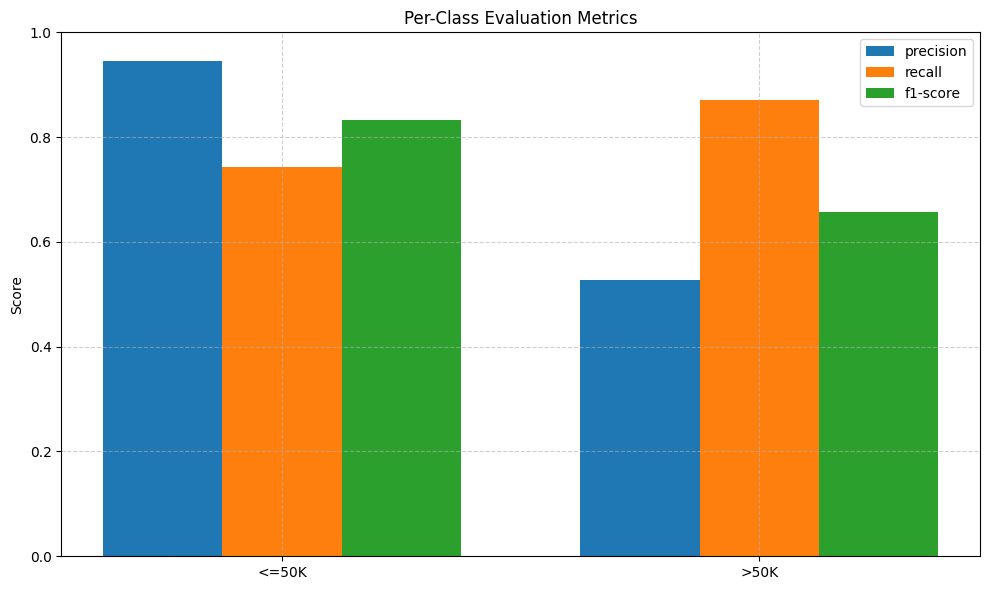

In [89]:
classes = ['<=50K', '>50K']
metrics = ['precision', 'recall', 'f1-score']

plt.figure(figsize=(10, 6))
for i, metric in enumerate(metrics):
    values = [cr[str(cls)][metric] for cls in [0, 1]]
    plt.bar([x + i*0.25 for x in range(len(classes))], values, width=0.25, label=metric)

plt.xticks([x + 0.25 for x in range(len(classes))], classes)
plt.ylabel("Score")
plt.title("Per-Class Evaluation Metrics")
plt.ylim(0, 1)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


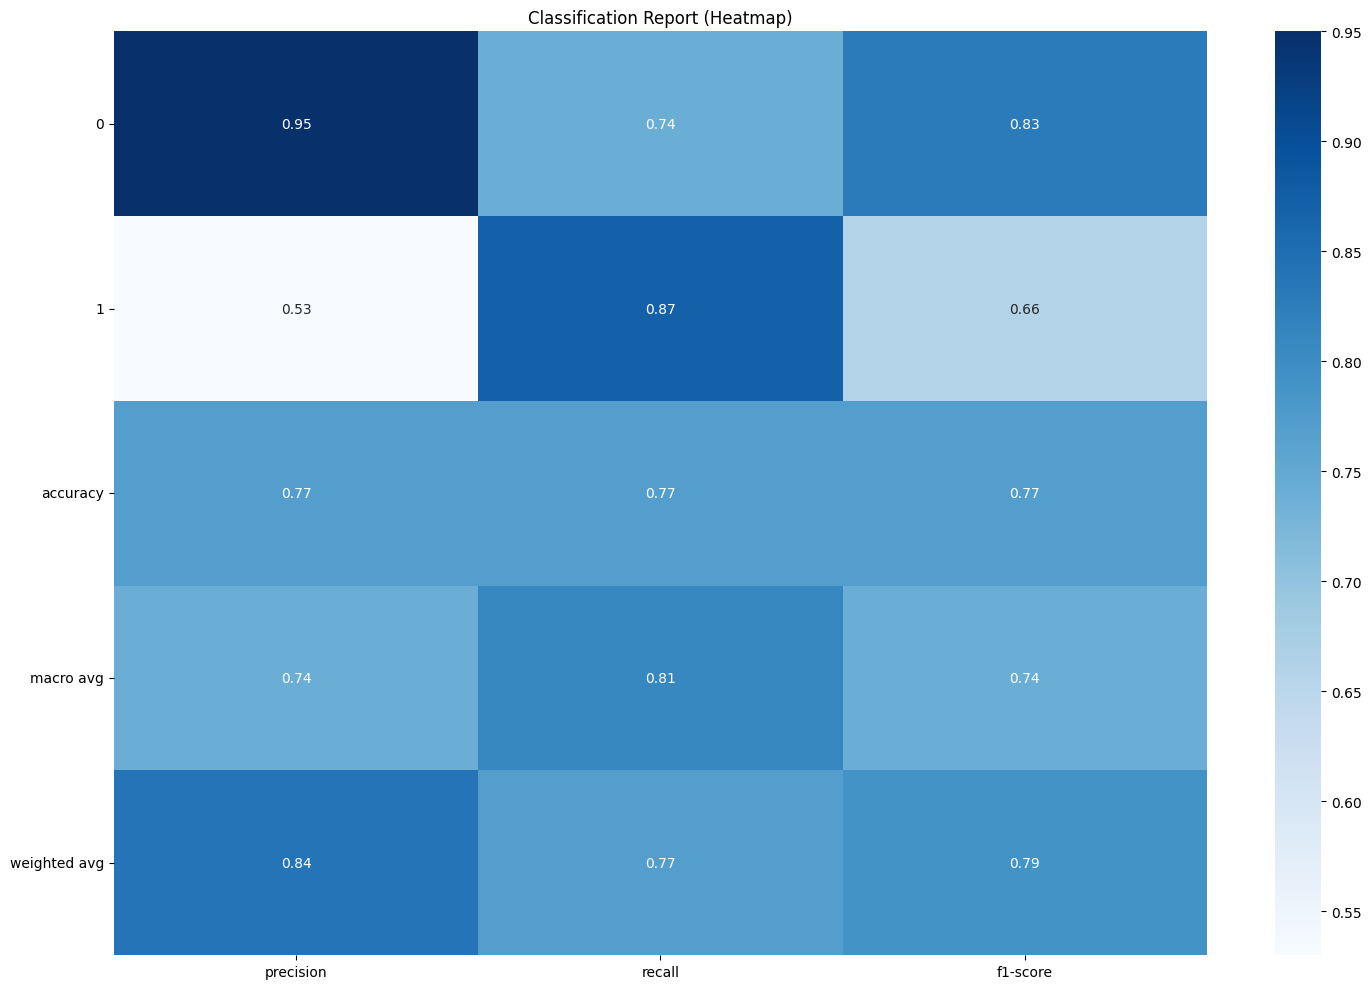

In [90]:
# cr_df = cr_df.drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore') # Drop 'accuracy', 'macro avg', 'weighted avg' if needed
cr_df = cr_df.round(2) # Optional: round to 2 decimals for cleaner heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(cr_df.iloc[:, :-1], annot=True, cmap='Blues', cbar=True, fmt='.2f')
plt.title("Classification Report (Heatmap)")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### ROC Curve Analysis

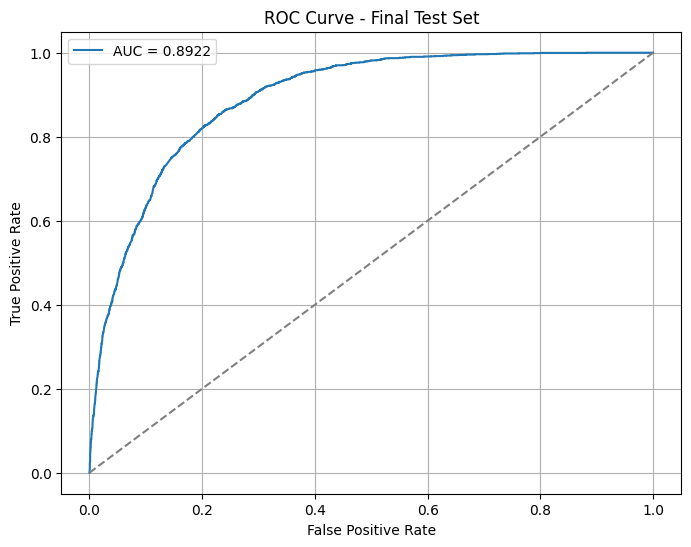

In [91]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {test_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Final Test Set")
plt.legend()
plt.grid(True)
plt.show()


### Precision-Recall Curve

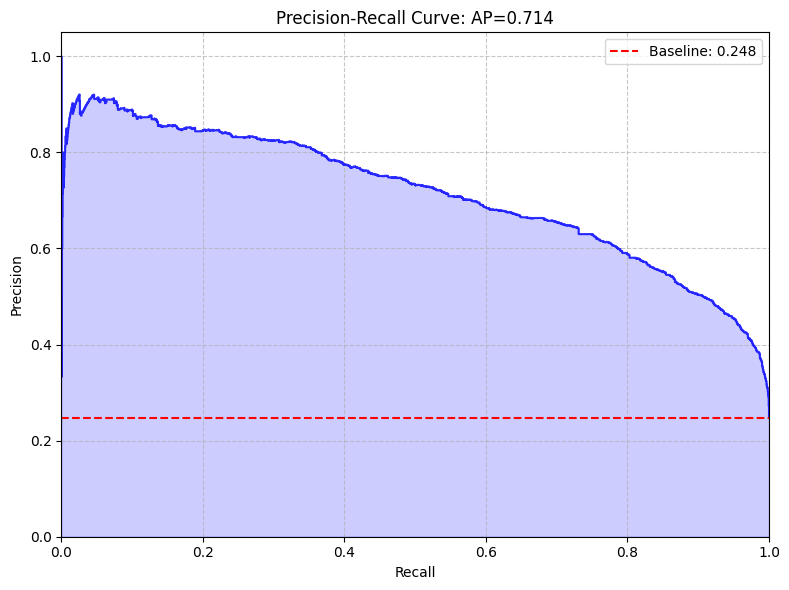

Average Precision Score: 0.7138


In [92]:
# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.8, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'Precision-Recall Curve: AP={average_precision:.3f}')
plt.grid(True, linestyle='--', alpha=0.7)

# Draw baseline
baseline = len(y_test[y_test==1]) / len(y_test)  # No skill: positive class proportion
plt.axhline(y=baseline, color='r', linestyle='--', label=f'Baseline: {baseline:.3f}')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Average Precision Score: {average_precision:.4f}")

## Model Interpretation & Insights

### Key Findings
Based on our exploratory data analysis and model results, we can draw several conclusions:
- **Education level** is strongly correlated with income, with higher education generally leading to higher income.
- **Hours worked per week** shows a positive correlation with income—those earning >$50K tend to work more hours.
- **Occupation categories** such as 'Executive-Managerial' and 'Professional-Specialty' are associated with higher income.
- **Relationship status** plays a significant role, with 'Husband' having higher representation in the >$50K category.
- **Age groups**: Middle-aged individuals are more likely to earn >$50K than young or old individuals.

### Model Performance Analysis

In [39]:
best_metrics = fold_metrics[best_fold_index - 1]
print(f"Best Fold = Fold {best_fold_index}")
print("Performance Metrics on Validation Set:")
for key, value in best_metrics.items():
    if key != 'fold':
        print(f"- {key.capitalize()}: {value:.4f}")

Best Fold = Fold 6
Performance Metrics on Validation Set:
- Accuracy: 0.7819
- Precision: 0.5392
- Recall: 0.8818
- Auc: 0.8981


The model shows stronger recall than precision for the high-income class, meaning it's better at identifying high-income individuals (fewer false negatives) but sometimes incorrectly classifies low-income individuals as high-income (more false positives).

### Feature Importance Observations

While we didn't explicitly calculate feature importance (e.g., using SHAP values), our EDA suggests these key predictors:

1. Education level (number of years)
2. Occupation type
3. Hours worked per week
4. Marital status/relationship
5. Age group (Middle-aged > Old > Young)

These insights align with common socioeconomic understanding that education, occupation, and work experience strongly influence income levels.

## Real-World Applications & Implications

### Use Cases in Financial Services

This income prediction model has several practical applications in the financial sector:

1. **Alternative Credit Scoring**: Supplement traditional credit scores for more inclusive lending, especially for "thin file" customers with limited credit history.
2. **Risk Assessment**: Enhance loan default prediction by adding income stability as a factor.
3. **Customer Segmentation**: Better tailor financial products based on predicted income brackets.
4. **Fraud Detection**: Flag inconsistencies between stated and predicted income as potential indicators of fraud.
5. **Financial Planning**: Help advisors understand client income potential for more personalized advice.

### Ethical Considerations

While powerful, these models raise important ethical considerations:

- **Fairness**: The model may perpetuate historical biases in income distribution across demographic groups.
- **Privacy**: Using demographic data for financial decisions raises privacy concerns.
- **Transparency**: Neural networks are "black box" models that may be difficult to explain to affected individuals.
- **Regulatory Compliance**: Financial institutions must ensure such models comply with fair lending laws.

### Limitations & Potential Improvements

Several limitations should be addressed in future work:

1. **Historical Data**: The dataset is from the 1990s and may not reflect current socioeconomic realities.
2. **Feature Engineering**: More sophisticated feature engineering could improve performance.
3. **Model Explainability**: Incorporating explainability techniques like SHAP would enhance transparency.
4. **Geographic Context**: Income significance varies by region; geographic normalization could help.

## Reflection

### Reflect on the challenges faced during the project and how they were addressed.

Several challenges were encountered during this project were:

### Discuss any insights gained from applying the selected method.

Insigts Gaind were encountered during this project were:

## Conclusion

This project successfully demonstrated that neural networks can effectively predict income levels based on demographic and employment data. The model's strong AUC score (~89%) indicates good discriminative ability, making it valuable for risk assessment applications in financial services.

The trade-off between precision and recall suggests that while the model is quite good at identifying high-income individuals (high recall), it sometimes incorrectly classifies low-income individuals as high-income (lower precision). This behavior should be considered when implementing such models in real-world scenarios, with appropriate thresholds set based on the specific use case requirements.

## References

1. UCI Machine Learning Repository: [Census Income Dataset](https://archive.ics.uci.edu/dataset/20/census+income)
2. TensorFlow Documentation: [Neural Networks with Keras](https://www.tensorflow.org/guide/keras/sequential_model)
3. Scikit-learn Documentation: [Model Evaluation](https://scikit-learn.org/stable/modules/model_evaluation.html)
6. Imbalanced Learning: [Class Weight Strategies](https://imbalanced-learn.org/)
7. Feature Engineering: [Preprocessing for Neural Networks](https://www.tensorflow.org/guide/keras/preprocessing_layers)